In [1]:
# !pip install chart_studio
!pip install nbformat==4.4.0
!pip install plotly==4.8.1


In [2]:
from datetime import datetime
import os
%load_ext google.colab.data_table
# %unload_ext google.colab.data_table
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.signal import savgol_filter
from sklearn.utils import shuffle
sns.set(rc={'figure.figsize':(35, 15)})

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Standard plotly imports
# import chart_studio.plotly as py
import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
path = "/content/drive/My Drive/"
path_jj = os.path.join(path, "Datasets", "Data_jj")

path_bm = os.path.join(path, "Datasets","Data_bm")
import cufflinks
# cufflinks.go_offline(connected=True)
# init_notebook_mode(connected=True)

pd.options.plotting.backend = "plotly"



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Utility Functions

In [3]:
def add_freq(df):
    """
    Adds time offset based on number of readings at each second
    Input:
    ====== 
    df: Sensor dataset 

 
    Output
    ======
    df: DataFrame with offset added to timestamp value
    
    """

    offsets = np.array([])
    # Creating offsets for each time value
    for freq in df.groupby("timestamp").count()['x']:
        offsets = np.append(offsets,np.linspace(0,1,freq))
    df["offset"] = offsets
    # Converting offsets to datetime format to allow addition to timestamp 
    df["offset"] = df.offset.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x))
    # Adding offset to timestamp value
    df["timestamp"] = df["timestamp"] + df["offset"]
    df = df.drop('offset',axis=1)
    return df


# This function creates "frames" by default
def convert_to_timeseries(df,offset = False):
    """
    Converts sensor dataframe to timeseries data. Each second represents a frame.
    """
    if 'timestamp' in df:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        if offset:
            df = add_freq(df)
        df = df.set_index('timestamp')
    return df

def preprocess_truth(df,time,keepNA = True):
    """
    Removes additional data from the "Truth" Dataframe and adds offset to Start time to align it with Actual trip time
    Input:
    ======
    df: Ground truth dataframe
    time: Start time of the trip
    keepNA: Boolean telling if Non Aggressive maneuvers should be removed or not
    
    Output
    ======
    maneuvers: DataFrame containing maneuvers and their actual start times.
    
    """

    # Removes Non-Aggressive maneuvers from the dataset
    maneuvers = df[df["Event"] != "Non-aggressive event"].iloc[:,:2]
    
    if keepNA:
        maneuvers = df.iloc[:,:2]

    maneuvers["Start"] = maneuvers.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)) + time
    maneuvers = maneuvers.reset_index(drop =True)
    return maneuvers


def get_trip_duration(df):
    return df.index.max()- df.index.min()

def create_time_segments(df,nf):
    """
    Input:
    ======
    df: Sensor dataframe e.g. accel, gyro, magnet
    nf: number of frames that make up a time segement
    
    Output
    ======
    windows: A dictionary with i mapped to list of timestamps(frames) that make up the ith segment.
             Number of windows = total frames - nf + 1
    """
    
    # Each timestamp represents one frame
    frames = df.index.unique()
    windows = {}
    
    # Number of frames in a trip
    total_frames = len(frames)
    
    for i in range(0,total_frames - nf + 1,2):
        
        # maps window i to the list of frames that make up the ith window
        windows[i] = frames[i:i+nf]    
        
        # reverses the order of the list so that frame of the current second i.e. last timestamp is represented by 0th frame.
        # windows[i] = windows[i][::-1]
    return windows


def create_time_windows(df,nf):
    """
    Input:
    ======
    df: Sensor dataframe e.g. accel, gyro, magnet
    nf: number of frames that make up a time window
    
    Output
    ======
    windows: A dictionary with i mapped to list of timestamps(frames) that make up the ith window.
             Number of windows = total frames - nf + 1
    """
    
    # Each timestamp represents one frame
    frames = df.index.unique()
    windows = {}
    
    # Number of frames in a trip
    total_frames = len(frames)
    
    for i in range(total_frames - nf + 1):
        
        # maps window i to the list of frames that make up the ith window
        windows[i] = frames[i:i+nf]    
        
        # reverses the order of the list so that frame of the current second i.e. last timestamp is represented by 0th frame.
        # windows[i] = windows[i][::-1]
    return windows
    
def create_attribute_dict(sensor_axis,window):
    """
    Input:
    ======
    sensor_axis: Series of sensor's axis from which attributes will be calculated.e.g. accel['x'] or accel['y']
    window: Time window for which the attributes will be calculated
    
    Output
    ======
    attribute_dict: A dictionary with keys  "mean, median, std, tendency" mapped to lists containing the respective
                    quantities, calculated for each frame in the window as described by the following paper:
                    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0174959.
    """
    
    attribute_dict = {}
    for i in range(1,len(window)+1):
        
        # Calculates quantities for the frame of current second
        if i == 1:
            attribute_dict["mean"] =[sensor_axis.loc[window[:i]].mean()]
            attribute_dict["median"] = [sensor_axis.loc[window[:i]].median()]
            attribute_dict["std"] = [sensor_axis.loc[window[:i]].std()]
            attribute_dict["tendency"] = []
        
        # Calculates quantities for the remaining frames
        else:
            attribute_dict["mean"].append(sensor_axis.loc[window[:i]].mean())
            attribute_dict["median"].append(sensor_axis.loc[window[:i]].median())
            attribute_dict["std"].append(sensor_axis.loc[window[:i]].std())
            attribute_dict["tendency"].append(sensor_axis.loc[window[i-1]].mean()/attribute_dict["mean"][0])
            
    return attribute_dict

def create_attribute_vector(attribute_dict):
    """
    Input:
    ======
    attribute_dict: Dictionary containing attributes to be converted to vector
    
    Output
    ======
    attribute_vector: attribute vector for a single axis of sensor data
    """
    vector = []
    for i in attribute_dict.values():
        vector.extend(i)
    return vector

def time_in_range(t,frame_list):
    """
    Returns true if t lies in the the time time window defined by the frame_list
    Input:
    ======
    t: Timestamp to be checked
    frame_list: list of frmes
    
    Output
    ======
    True, If timestamp is in the range, False otherwise
    """
    if t>=frame_list.min() and t<=frame_list.max():
        return True
    return False


def savgol(sensor, window_length = 51, polyorder = 2 ):
    """
    This applies savgol filter to sensor data, inplace
    ======
    sensor: sensor to be normalized
    window_length: Set as 51 after rigourous testing
    polyorder: set as 2
    """
    sensor['x'] = savgol_filter(sensor['x'].values, window_length, polyorder)
    sensor['y'] = savgol_filter(sensor['y'].values, window_length, polyorder)
    sensor['z'] = savgol_filter(sensor['z'].values, window_length, polyorder)


## Functions that work on one sensor at a time

In [4]:
def process_sensor(df_sensor, df_truth, nf = 3, axis_list = ['x'], ours = False):
    """
    Assumes that at any given time, there is only one event/maneuver happening at max.
    Input:
    ======
    df_sensor: Dataframe containing sensor data e.g. accel, gyro, magnet
    df_truth: Dataframe containing ground truth label
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    
    Output
    ======
    processed: list of tuples of the form (vectors,label) where vectors is a dictionary with 
                axis name as key and attribute vector as value
    """
    savgol(df_sensor)
    if not ours: 
        df_sensor = convert_to_timeseries(df_sensor)
        # Start time of trip to adjust "Start" Column in ground truth table
        start_time = df_sensor.index.min()
        # Removing non-aggressive events from the table and adjusting Start time 

        df_truth = preprocess_truth(df_truth,start_time)
    
    # creating Sliding windows
    windows = create_time_windows(df_sensor,nf)
    
    
    processed = []
    
    # Tracks number of maneuvers identified
    i=0
    found = False
    
    for window, frames in windows.items():
        
        # Checks if any maneuver occurs in the time window
        if time_in_range(df_truth["Start"][i],frames):
            found = True
            attr_vectors = {}
            
            # Calculates attributes for each axis of the sensor
            for axis in axis_list:
                attr_dict = create_attribute_dict(df_sensor[axis],frames)
                attr_vectors[axis] = create_attribute_vector(attr_dict)
            
            label = df_truth["Event"][i]
            processed.append((attr_vectors,label))
        # Returns the list if all maneuvers in the trip have been identified. Otherwise starts looking for next maneuver
        else:
            if found and len(df_truth) == i+1:
                return processed
            elif found:
                i += 1
                found = False               
    return processed

def create_dataframe(processed_sensor, nf, axis_list):
    """
    This creates the dataframe that we will be using to train out model
    Input:
    ======
    processed_sensor: list of tuples from process_sensor function
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    
    Output
    ======
    df: Dataframe containing attribute vectors in each row along with their respective labels
    """

    # Creating list skeleton for column names
    m = ["M{}".format(i) for i in range(nf)]
    md = ["MD{}".format(i) for i in range(nf)]
    std = ["SD{}".format(i) for i in range(nf)]
    t = ["T{}".format(i) for i in range(1,nf)]
    
    # Adjusts column names w.r.t axis
    col_names = m+md+std+t
    col_names = ["{}_{}".format(attrib,axis) for axis in axis_list for attrib in col_names]
    
    # Initializing data array and maneuver list
    data = np.array(list(processed_sensor[0][0].values())).ravel().reshape(1,-1)
    maneuver = [processed_sensor[0][1]]
    
    for vector,label in processed_sensor[1:]:
        row = np.array(list(vector.values())).ravel().reshape(1,-1)
        data = np.append(data,row,axis=0)
        maneuver.append(label)
    df = pd.DataFrame(data = data,columns=col_names)
    df['maneuver'] = maneuver
    return df




# Main Preprocessing Function

In [5]:

path16 = path + "/Datasets/Jain Jr Dataset/16/"

path17 = path + "/Datasets/Jain Jr Dataset/17/"

path20 = path +"/Datasets/Jain Jr Dataset/20/"

path21 = path +"/Datasets/Jain Jr Dataset/21/"



def process_path(source_path, dest_path = path, nf =3, axis_list = ["x","y","z"], export = False):
    """
    Generates dataframes for each trip that contain classified attribute vectors for each sensor
    Input:
    ======
    source_path: path to folder containing dataset
    dest_path: path to folder where processed dataset will be stored
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    export: Flag that if True, exports dataframes to processed.xslx
    
    Output
    ======
    list of Dataframes corresponding to each Sensor
    
    Sample Usages:
    ==============
    process_path(path16,export=True)
    process_path(path16, nf=4, axis_list = ['x','y','z'], export=True)
    
    """
    
    # lin_accel and accel differ only in z values
    linaccel = pd.read_csv(source_path +"aceleracaoLinear_terra.csv")
    
    # Sensor data sampled at 51Hz
    accel = pd.read_csv(source_path + "acelerometro_terra.csv")
    gyro = pd.read_csv(source_path + "giroscopio_terra.csv")
    # Sensor data sampled at 102Hz
    magnet = pd.read_csv(source_path + "campoMagnetico_terra.csv")

    
    # True event labels with start and finish time (seconds).
    truth = pd.read_csv(source_path + "groundTruth.csv")
    
    # Translating event labels from Portoguese to English
    portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 
                        'Aggressive left lane change','aceleracao_agressiva':'Aggressive acceleration',
                        'freada_agressiva':'Aggressive breaking','curva_esquerda_agressiva':'Aggressive left turn',
                        'curva_direita_agressiva':'Aggressive right turn','troca_faixa_direita_agressiva':
                        'Aggressive right lane change'}

    truth['evento'] = [portu_to_english[x] for x in truth['evento']]
    truth.columns = ["Event", "Start", "End"]
    
    print("Trip lasted for", get_trip_duration(convert_to_timeseries(magnet)))
    
    # Creating Dataframes consisting of attribute vectors and labels to train our model
    accel_processed = process_sensor(accel, truth, nf, axis_list)
    df_accel = create_dataframe(accel_processed, nf, axis_list)    
    gyro_processed = process_sensor(gyro, truth, nf, axis_list)
    df_gyro = create_dataframe(gyro_processed, nf, axis_list)  
    magnet_processed = process_sensor(magnet, truth, nf, axis_list)
    df_magnet = create_dataframe(magnet_processed, nf, axis_list)  
    linaccel_processed = process_sensor(linaccel, truth, nf, axis_list)
    df_linaccel = create_dataframe(linaccel_processed, nf, axis_list)  
 
    # Exports dataframes to processed.xslx file
    if export:
        with pd.ExcelWriter(dest_path) as writer:
            df_accel.to_excel(writer, sheet_name = 'Acclerometer')
            df_linaccel.to_excel(writer, sheet_name = 'Linear_Acceleration')
            df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
            df_magnet.to_excel(writer, sheet_name = 'Magnetometer')
            truth.to_excel(writer, sheet_name = 'Events')
            
    return [df_accel,df_magnet,df_gyro,df_linaccel]

# Run to generate CSVs of processed data

# Extremely computationallly extensive task
# d1 = process_path(path16, dest_path = path +"processed16.xlsx" , nf= 8)
# d2 = process_path(path17, dest_path = path +"processed17.xlsx", nf = 8)
# d3 = process_path(path20, dest_path = path +"processed20.xlsx", nf = 8)
# d4 = process_path(path21, dest_path = path +"processed21.xlsx", nf = 8)

# Loading **Data**

In [6]:
path16 = path_jj +"/16/"

path17 = path_jj + "/17/"

path20 = path_jj +"/20/"

path21 = path_jj +"/21/"


portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 'Aggressive left lane change',
                    'aceleracao_agressiva':'Aggressive acceleration','freada_agressiva':'Aggressive breaking',
                   'curva_esquerda_agressiva':'Aggressive left turn','curva_direita_agressiva':'Aggressive right turn',
                  'troca_faixa_direita_agressiva':'Aggressive right lane change'}

accel1 = pd.read_csv(path16 + "acelerometro_terra.csv")
magnet1 = pd.read_csv(path16 + "campoMagnetico_terra.csv")
gyro1 = pd.read_csv(path16 + "giroscopio_terra.csv")
truth1 = pd.read_csv(path16 + "groundTruth.csv")
truth1['evento'] = [portu_to_english[x] for x in truth1['evento']]
truth1.columns = ["Event", "Start", "End"]

accel2 = pd.read_csv(path17 + "acelerometro_terra.csv")
magnet2 = pd.read_csv(path17 + "campoMagnetico_terra.csv")
gyro2 = pd.read_csv(path17 + "giroscopio_terra.csv")
truth2 = pd.read_csv(path17 + "groundTruth.csv")
truth2['evento'] = [portu_to_english[x] for x in truth2['evento']]
truth2.columns = ["Event", "Start", "End"]

accel3 = pd.read_csv(path20 + "acelerometro_terra.csv")
magnet3 = pd.read_csv(path20 + "campoMagnetico_terra.csv")
gyro3 = pd.read_csv(path20 + "giroscopio_terra.csv")
truth3 = pd.read_csv(path20 + "groundTruth.csv")
truth3['evento'] = [portu_to_english[x] for x in truth3['evento']]
truth3.columns = ["Event", "Start", "End"]

accel4 = pd.read_csv(path21 + "acelerometro_terra.csv")
magnet4 = pd.read_csv(path21 + "campoMagnetico_terra.csv")
gyro4 = pd.read_csv(path21 + "giroscopio_terra.csv")
truth4 = pd.read_csv(path21 + "groundTruth.csv")
truth4['evento'] = [portu_to_english[x] for x in truth4['evento']]
truth4.columns = ["Event", "Start", "End"]

"""
Run this if you want to visualize feature variables
"""


accel1 = convert_to_timeseries(accel1, True)
magnet1 = convert_to_timeseries(magnet1, True)
gyro1 = convert_to_timeseries(gyro1, True)

start_time = accel1.index.min()
truth1['Start'] = truth1.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth1["End"] = truth1.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel2 = convert_to_timeseries(accel2, True)
magnet2 = convert_to_timeseries(magnet2, True)
gyro2 = convert_to_timeseries(gyro2, True)

start_time = accel2.index.min()
truth2['Start'] = truth2.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth2['End'] = truth2.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel3 = convert_to_timeseries(accel3, True)
magnet3 = convert_to_timeseries(magnet3, True)
gyro3 = convert_to_timeseries(gyro3, True)

start_time = accel3.index.min()
truth3['Start'] = truth3.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth3['End'] = truth3.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel4 = convert_to_timeseries(accel4, True)
magnet4 = convert_to_timeseries(magnet4, True)
gyro4 = convert_to_timeseries(gyro4, True)

start_time = accel4.index.min()
truth4['Start'] = truth4.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth4['End'] = truth4.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

# add_event_label(accel1,truth1)
# add_event_label(gyro1,truth1)
# add_event_label(magnet1,truth1)
# add_event_label(accel2,truth2)
# add_event_label(gyro2,truth2)
# add_event_label(magnet2,truth2)

# add_event_label(accel3,truth3)
# add_event_label(gyro3,truth3)
# add_event_label(magnet3,truth3)

# add_event_label(accel4,truth4)
# add_event_label(gyro4,truth4)
# add_event_label(magnet4,truth4)


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning:

Adding/subtracting array of DateOffsets to DatetimeArray not vectorized



In [7]:
for i in range(2):
    savgol(accel1)
    savgol(magnet1)
    savgol(gyro1,window_length=31,polyorder=3)

    savgol(accel2)
    savgol(magnet2)
    savgol(gyro2,window_length=31,polyorder=3)

    savgol(accel3)
    savgol(magnet3)
    savgol(gyro3,window_length=31,polyorder=3)

    savgol(accel4)
    savgol(magnet4)
    savgol(gyro4,window_length=31,polyorder=3)

# Visualizations

## Helper functions

In [8]:
def plot_instance(sensor_list, start, end, axes= ["x","y","z"], offset = 2):
    """
    Plots one instance of any maneuver between start and end time
    """
    plt.figure(figsize = (35,4.8))
   # size = plt.fig.get_figwidth(), fig.get_figheight()
    plt.tight_layout()
    plt.autoscale()
    offset = pd.tseries.offsets.DateOffset(seconds= offset)
    r = len(sensor_list)
    subplot = 1
    for sensor in sensor_list:   
        mask = (sensor.index >= (start-offset)) & (sensor.index <=(end + offset))
        num = 100 + r*10 + subplot
        plt.subplot(num)
        for axis in axes:
            plt.axvspan(start, end, color='#FF9379', alpha=0.2)
            plt.plot(sensor.index[mask], sensor[mask][axis])
        plt.legend(["x","y","z"])
        # plt.title("Sensor {}".format(subplot))
        titles = ["Accelerometer", "Gyroscope","Magnetometer"]
        plt.title(titles[(subplot-1)])
        subplot+=1
        
def plot_event(sensor_list,df_truth, event, axes= ["x","y","z"], offset=2):
    """
    Plots all instances of a maneuver in a given trip
    """
    e = df_truth[df_truth["Event"] == event]
    for i in range(e.count()[0]):
        plot_instance(sensor_list, e.iloc[i]['Start'], e.iloc[i]['End'], axes, offset)

# Aggressive Lateral Maneuvers

## Aggressive right lane change
We can observe a sine wave in accel y, and a flipped sine wave in accel x, with amplitude ~ 5.



Additionally,we can observe a flipped sine wave in gyroscope z, with an amplitude > 0.4. Plotting all samples also show that the gyroscope sine wave being flipped or not is a good way to distinguish between left and right lane changes.

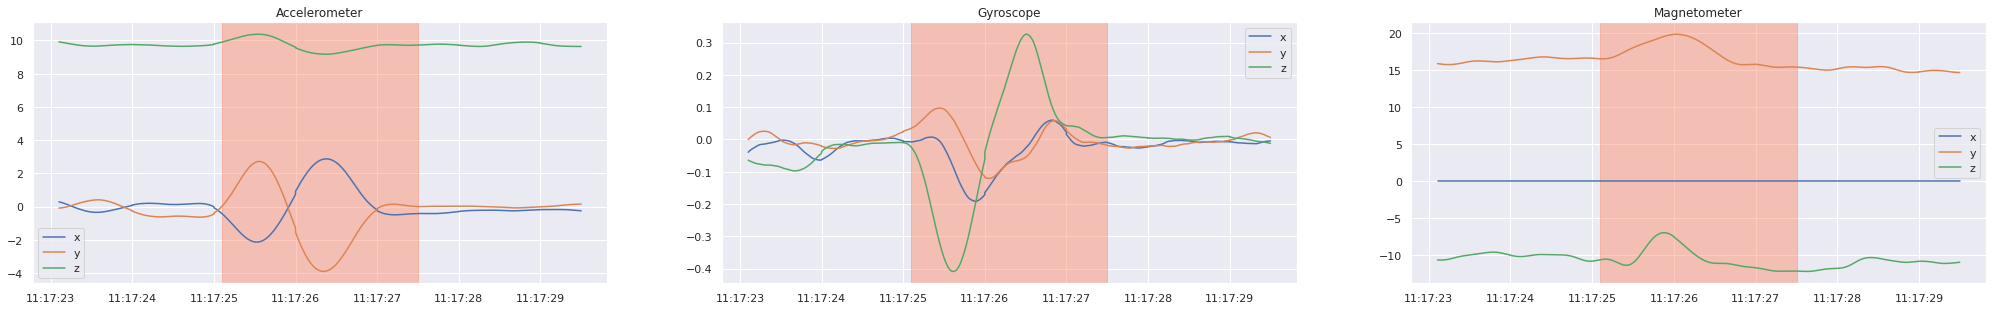

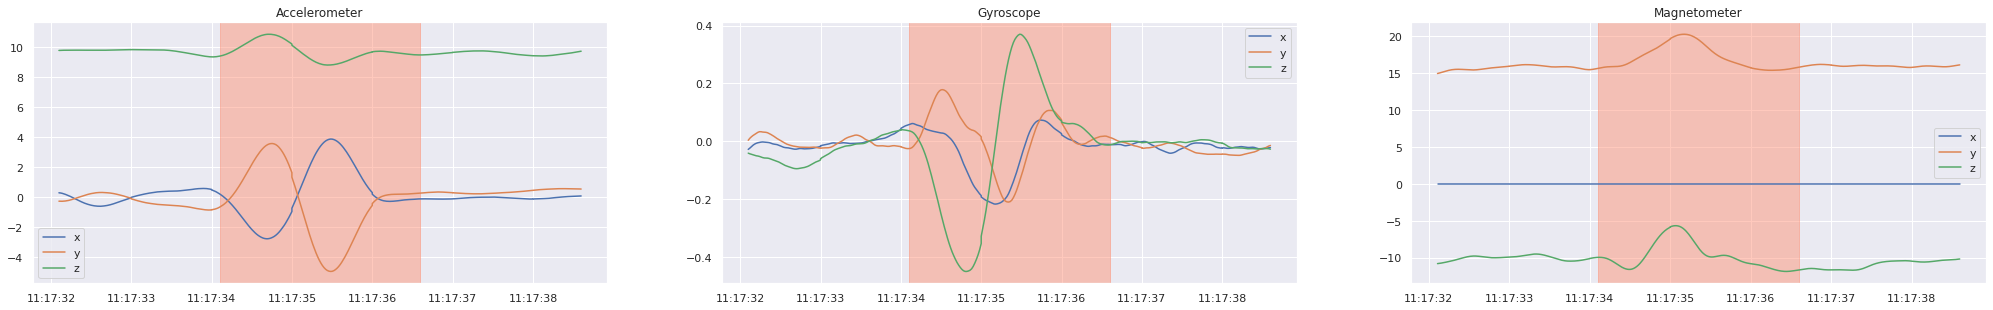

In [9]:
plot_event([accel2,gyro2,magnet2], truth2, "Aggressive right lane change")

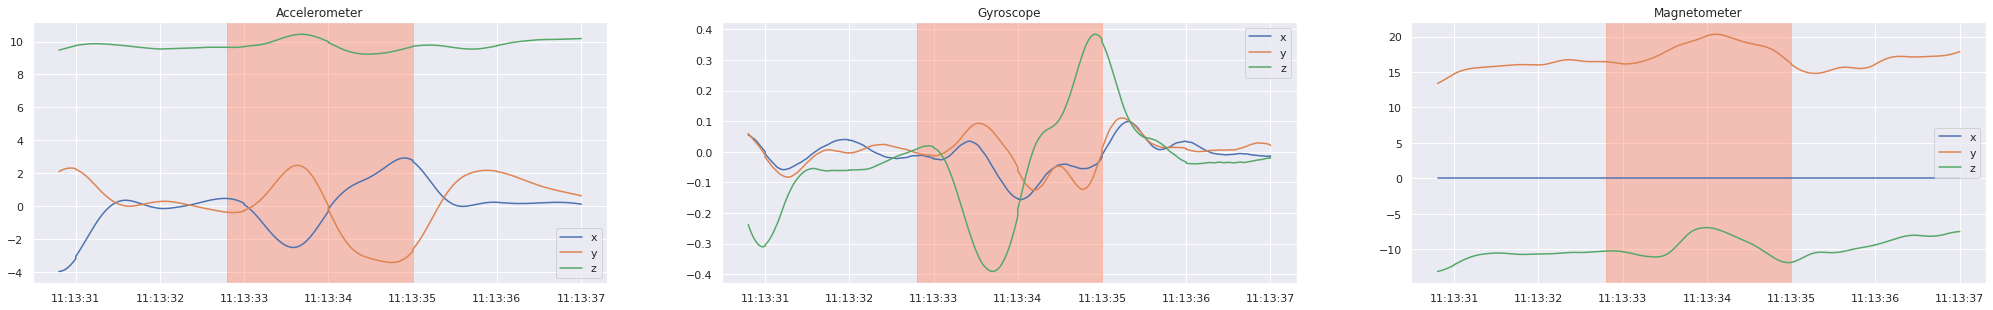

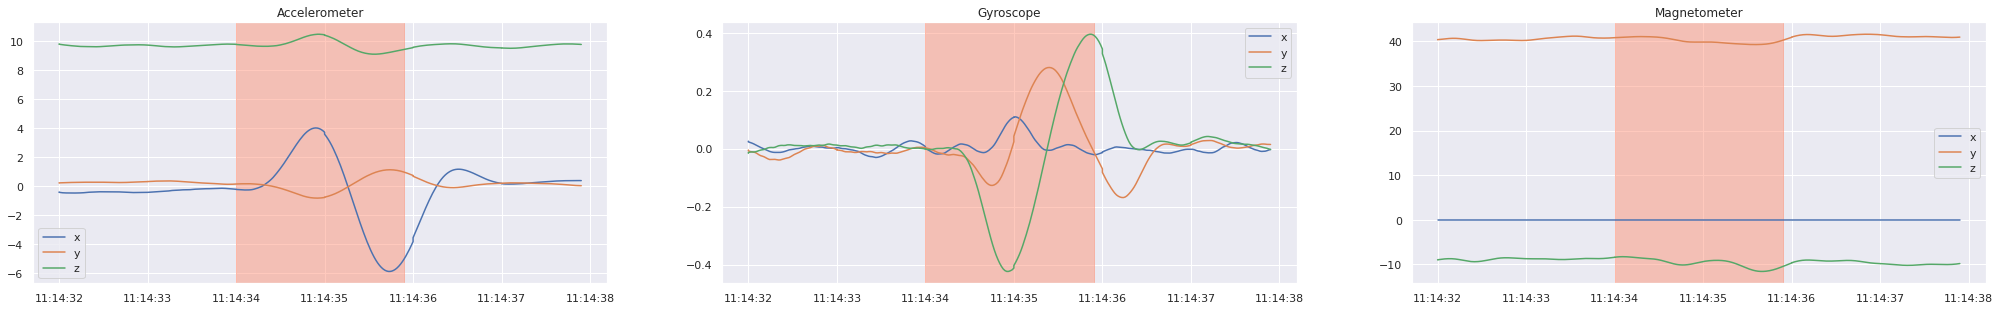

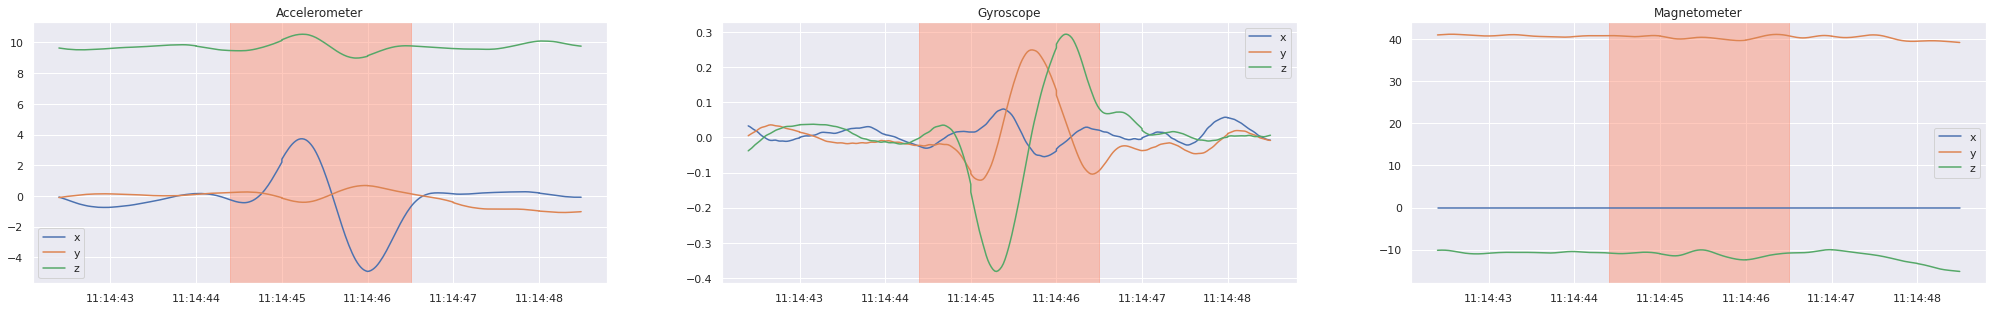

In [ ]:
plot_event([accel1,gyro1,magnet1], truth1, "Aggressive right lane change")

## Aggressive Left Lane Change

Gyroscope has a a sine wave with peak at the start of the maneuever, as expected. (since the pattern should be opposite to that in Right lane change. The amplitude > 0.4 only during maneuver interval.

Accelerometer exhibits a similar pattern as in "Right lane change maneuver. Again, as expected.

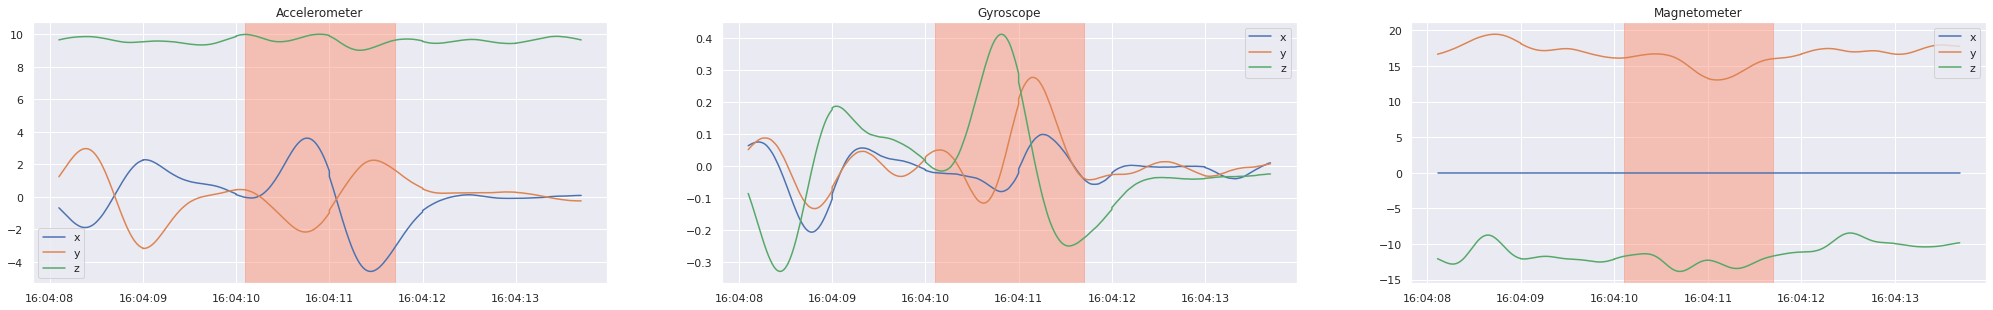

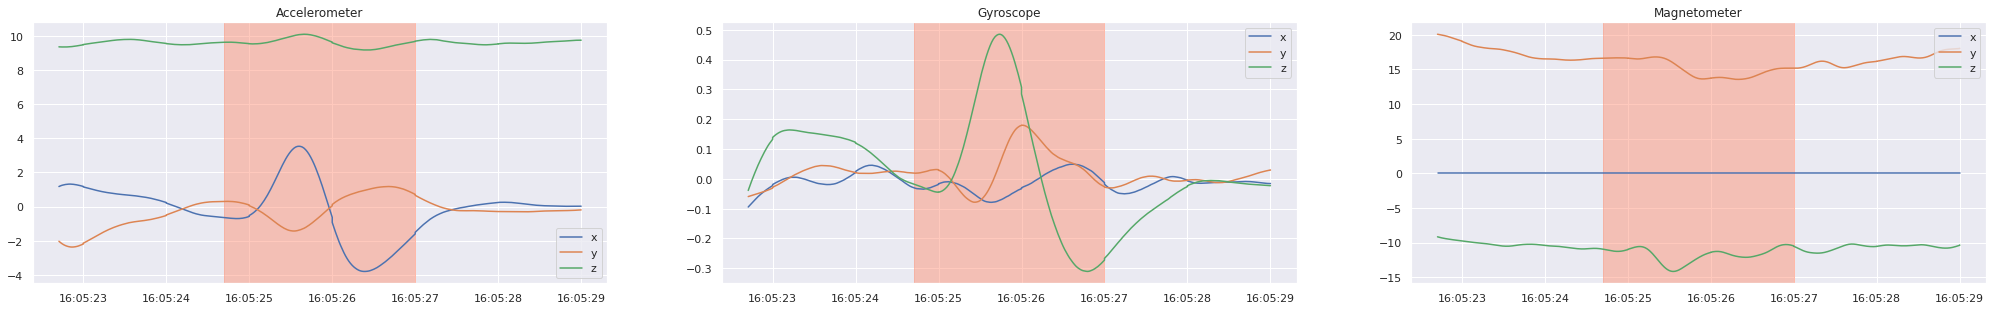

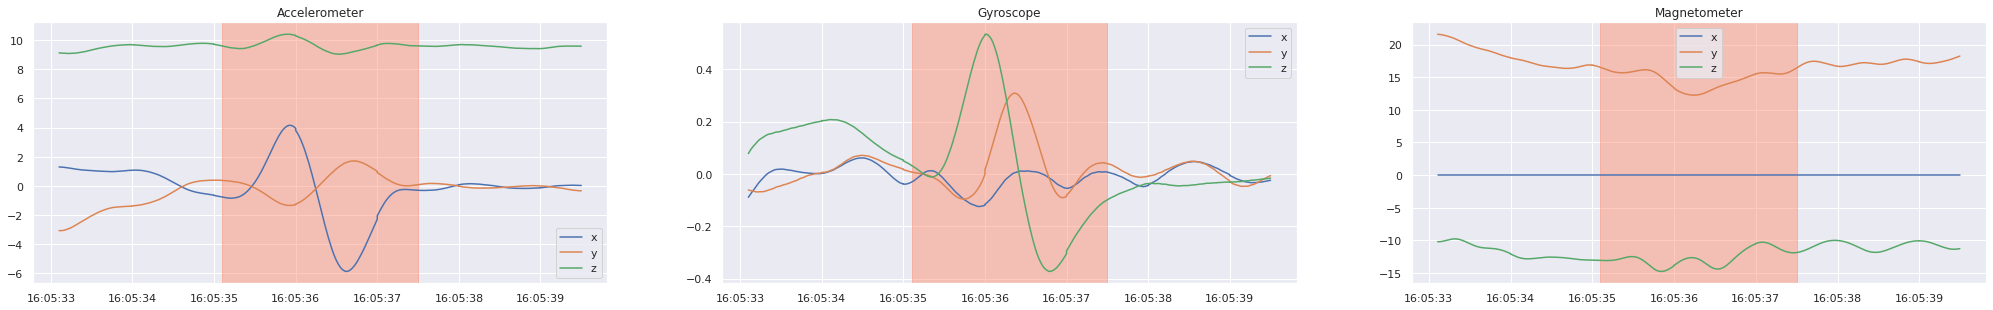

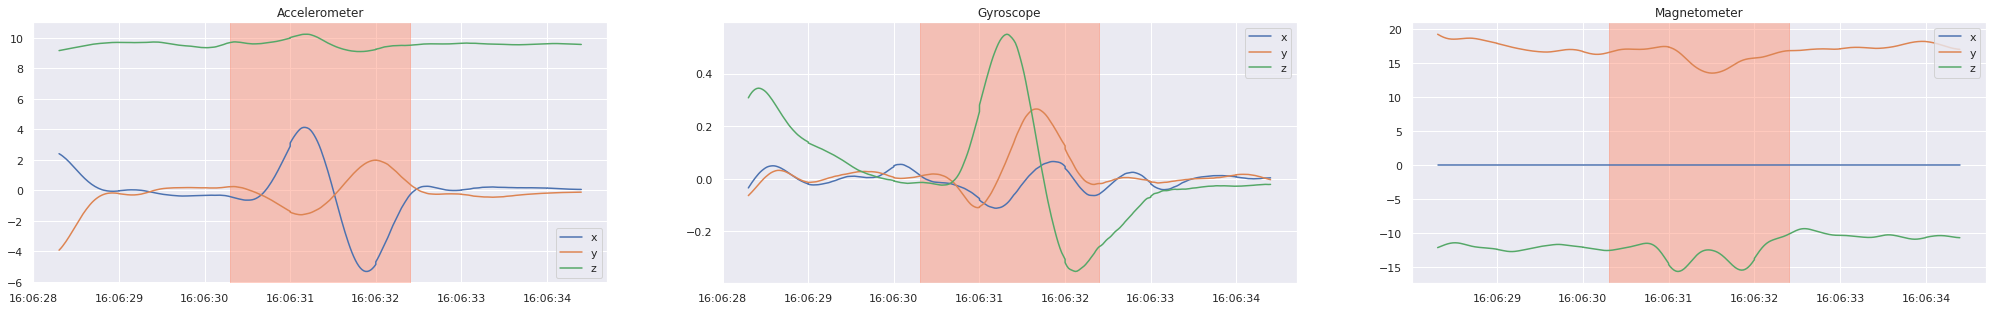

In [ ]:
plot_event([accel4,gyro4,magnet4],truth4,"Aggressive left lane change")

## Aggressive right turn

We can observe a low peak in gyro z and high peak in gyro x, with amplitude ~ 0.8 and higher. This is a good indicator for the maneuver as this pattern isn't observed in other maneuvers.

The Accelerometer pattern exhibits a similar pattern to the lane chane maneuvers, with x value reaching an amplitude ~5 during the maneuver.

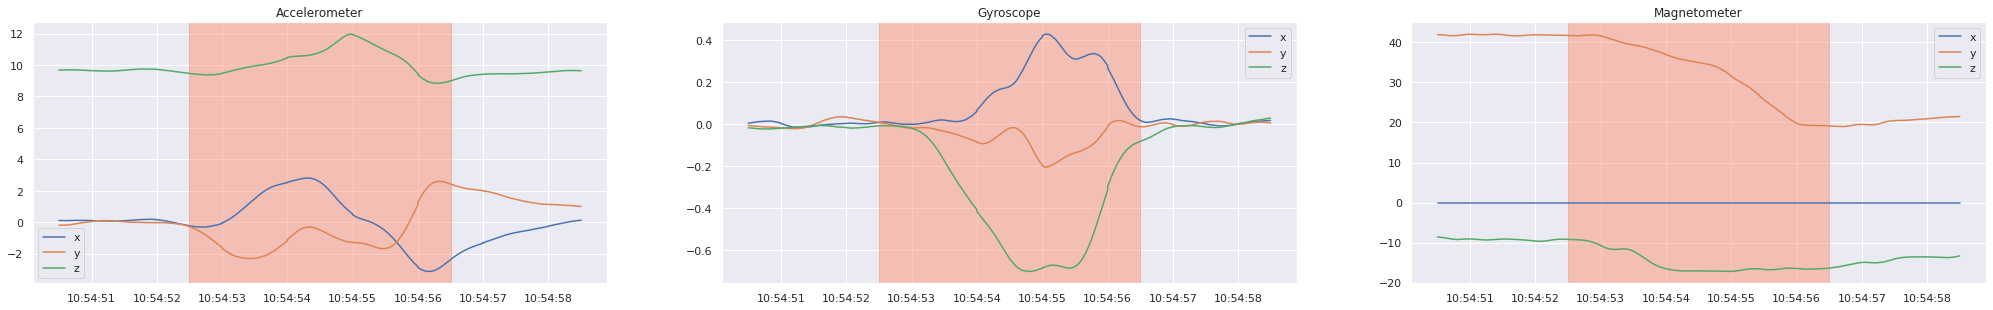

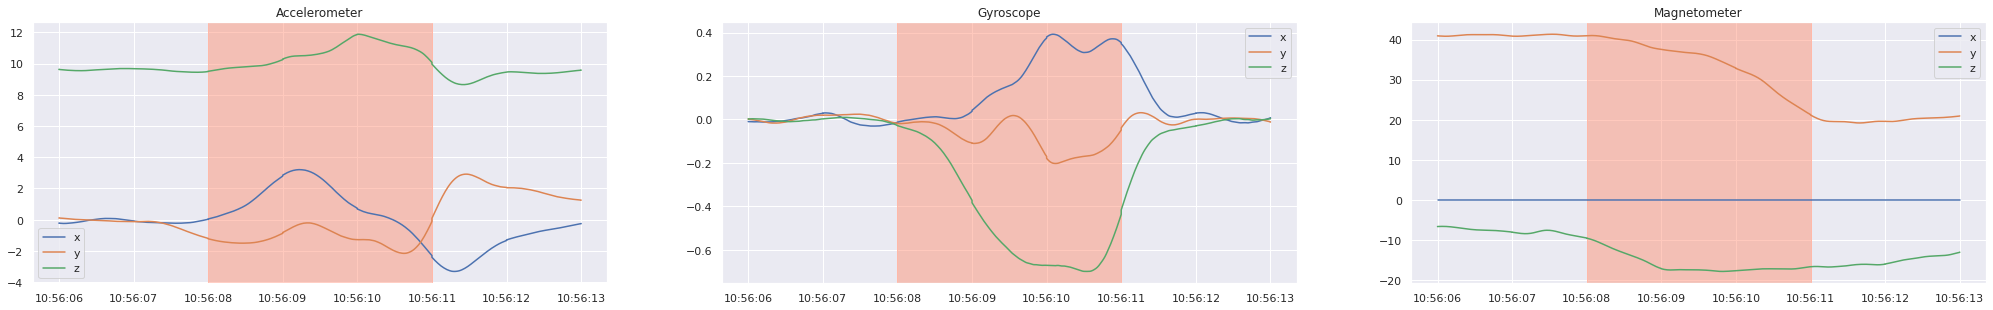

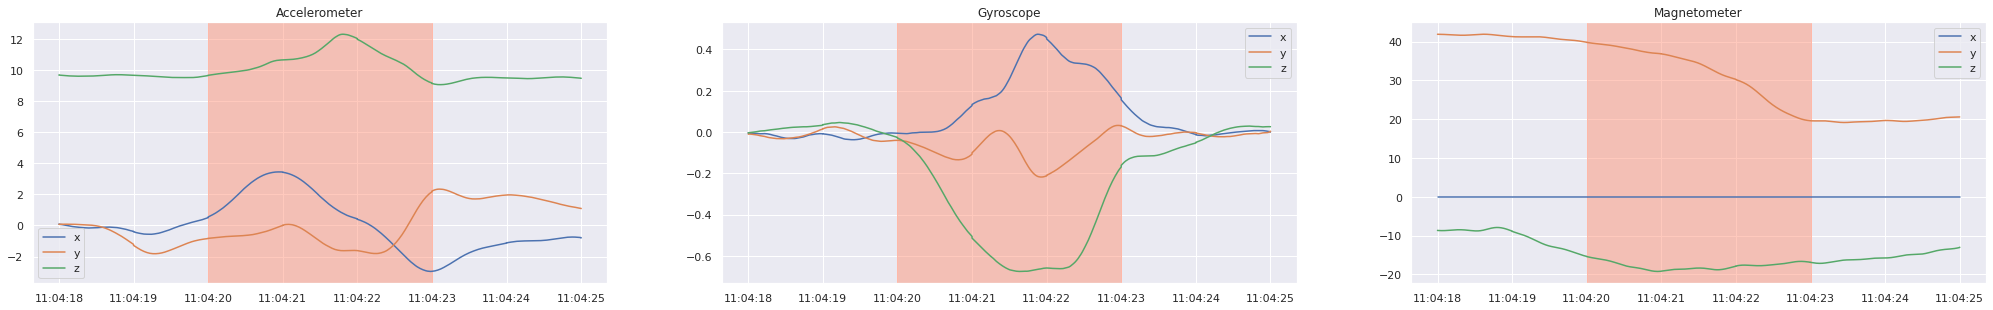

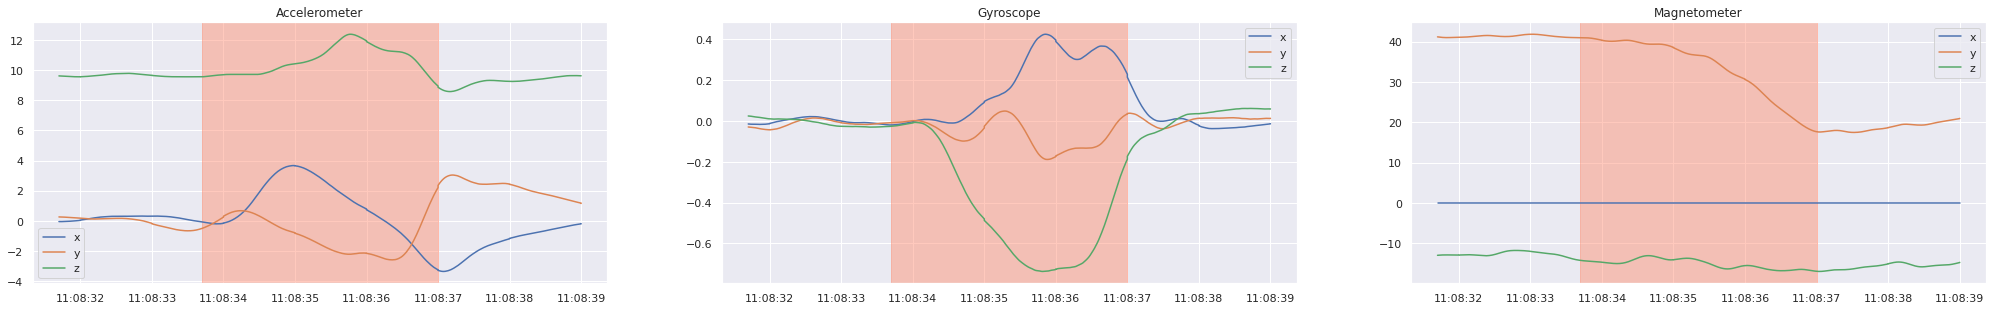

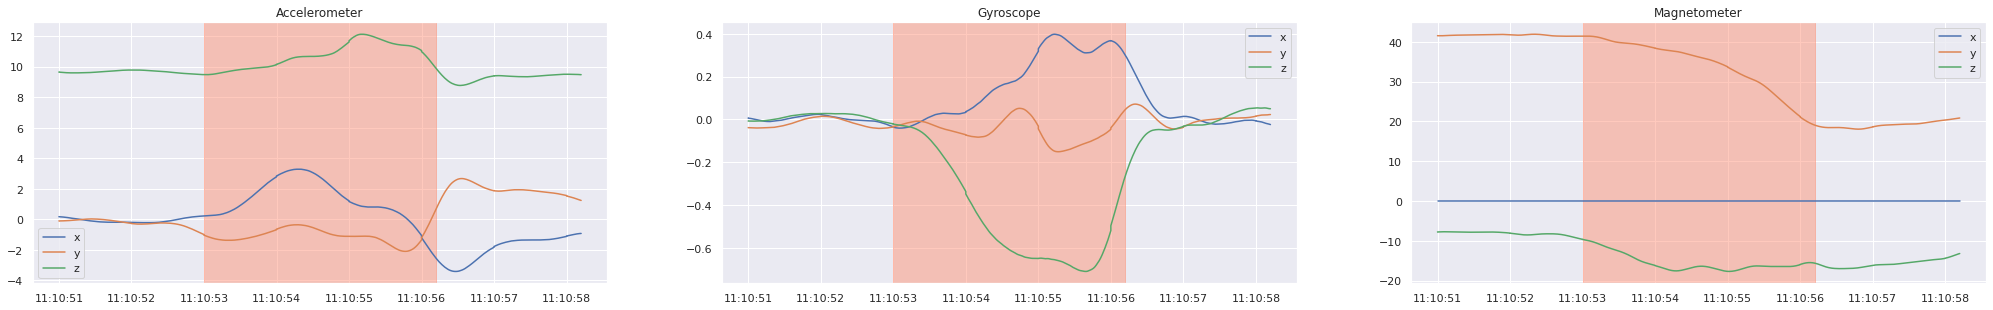

In [ ]:
plot_event([accel1,gyro1, magnet1], truth1, "Aggressive right turn")

## Aggressive left turn

A similiar pattern is observed with "Aggressive right turn" with the main difference being that the x-z roles are reveresed in gyroscope data.

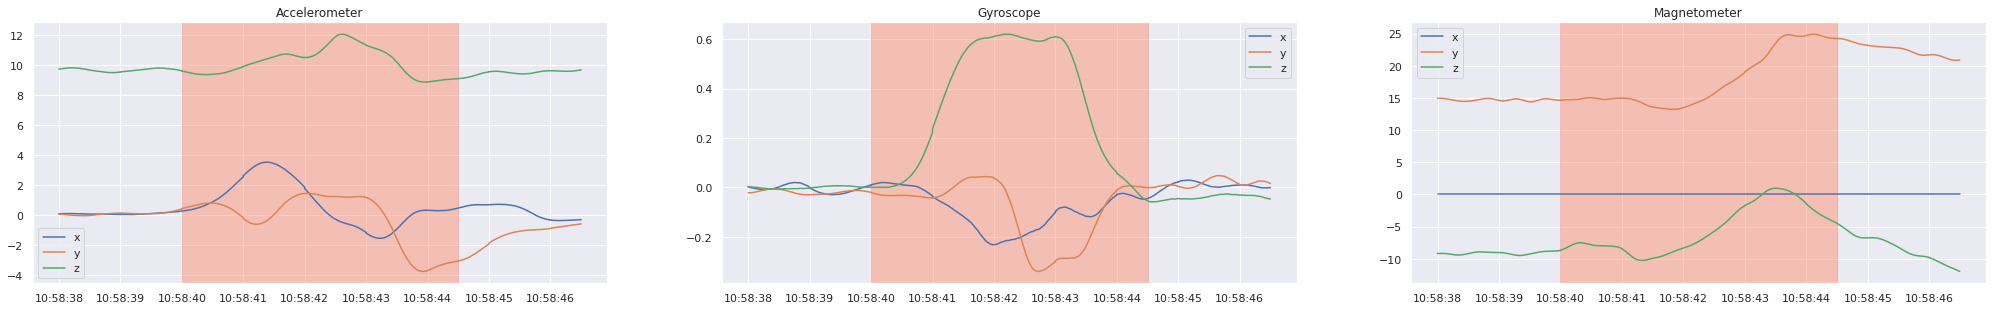

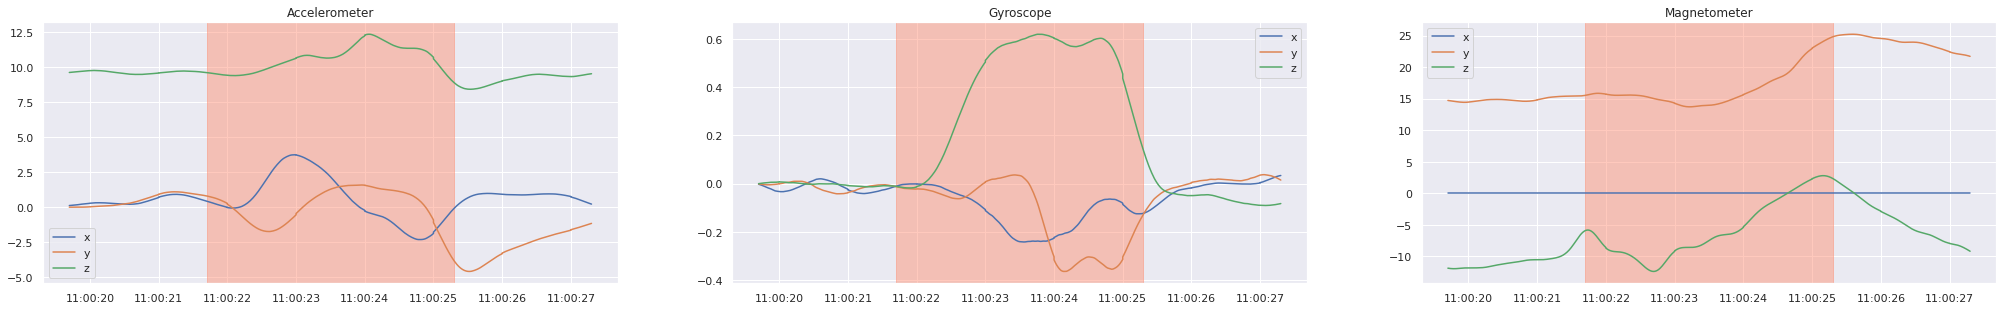

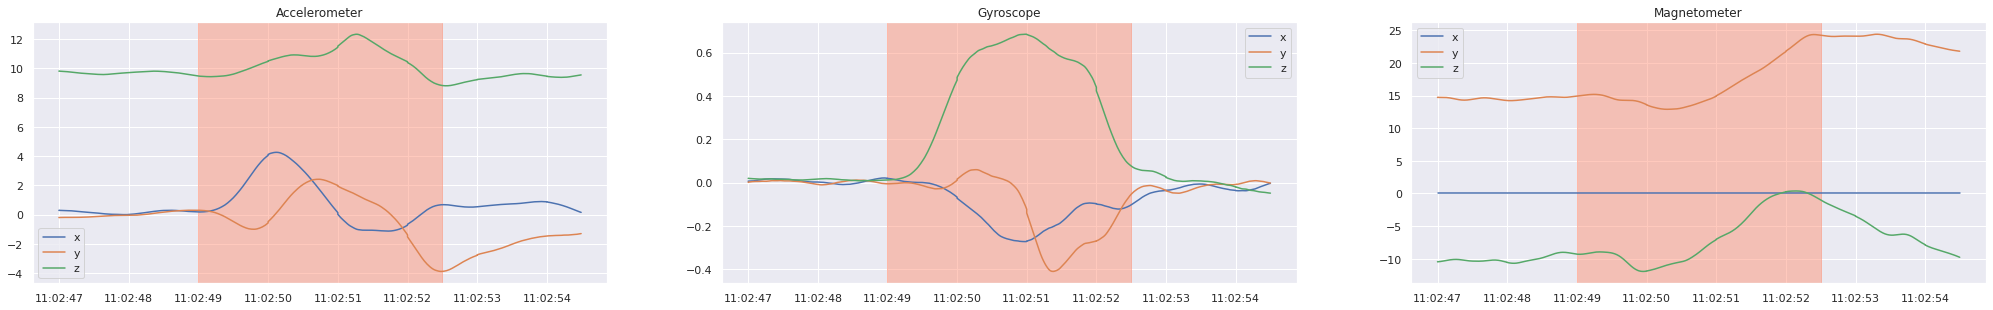

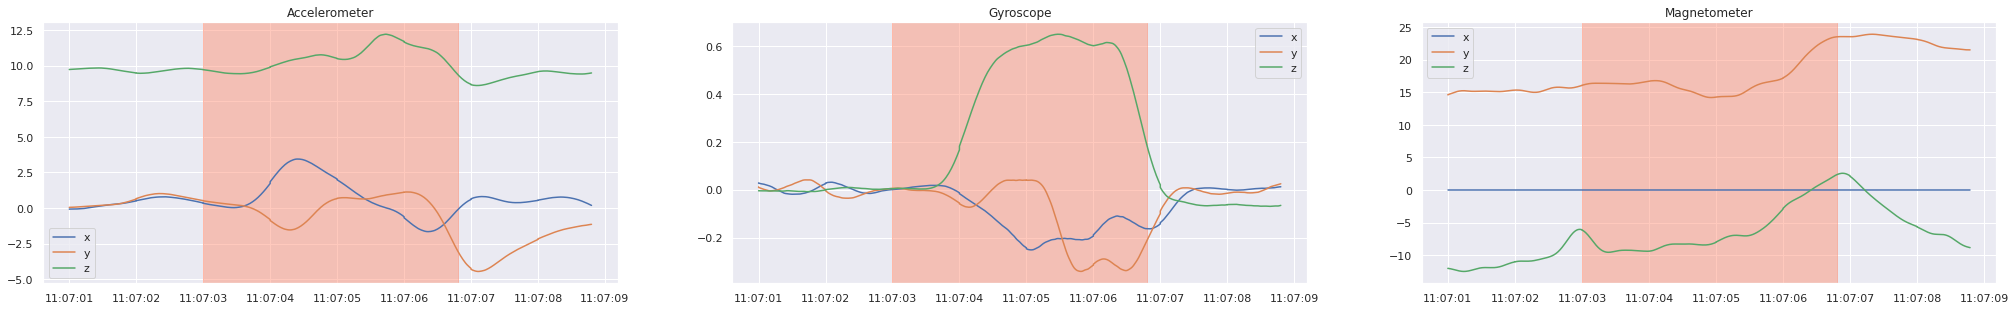

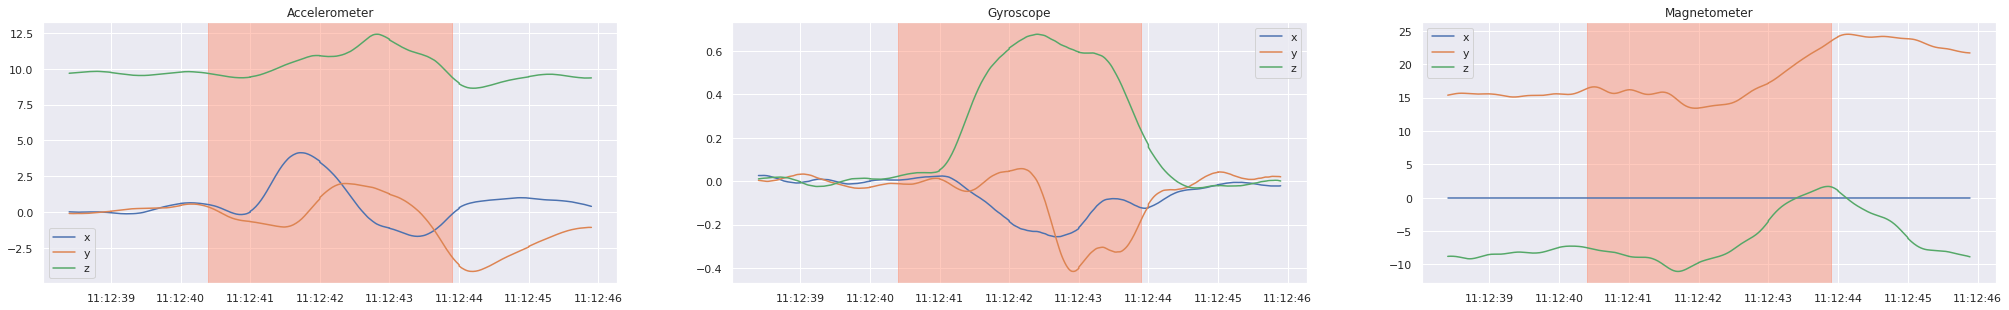

In [ ]:
plot_event([accel1,gyro1, magnet1], truth1, "Aggressive left turn")

# Aggressive Longitudinal Maneuvers

## Aggressive Breaking
Accelerometer shows a unique $\alpha$ shape which can serve as a marker for this maneuver, ranging from +-5

The gyroscope data doesn't contribute to analysis

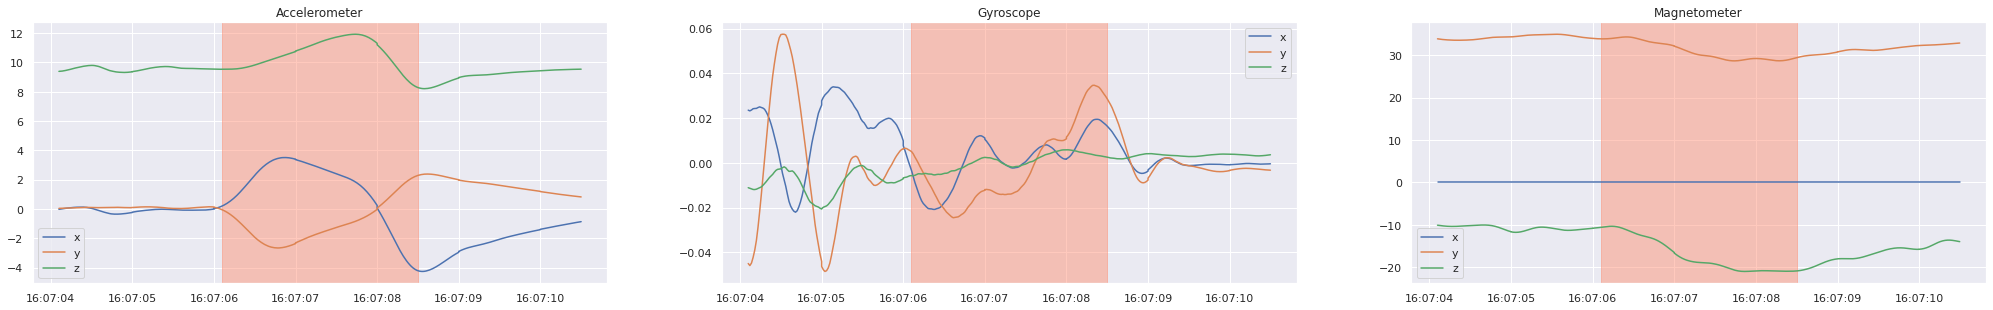

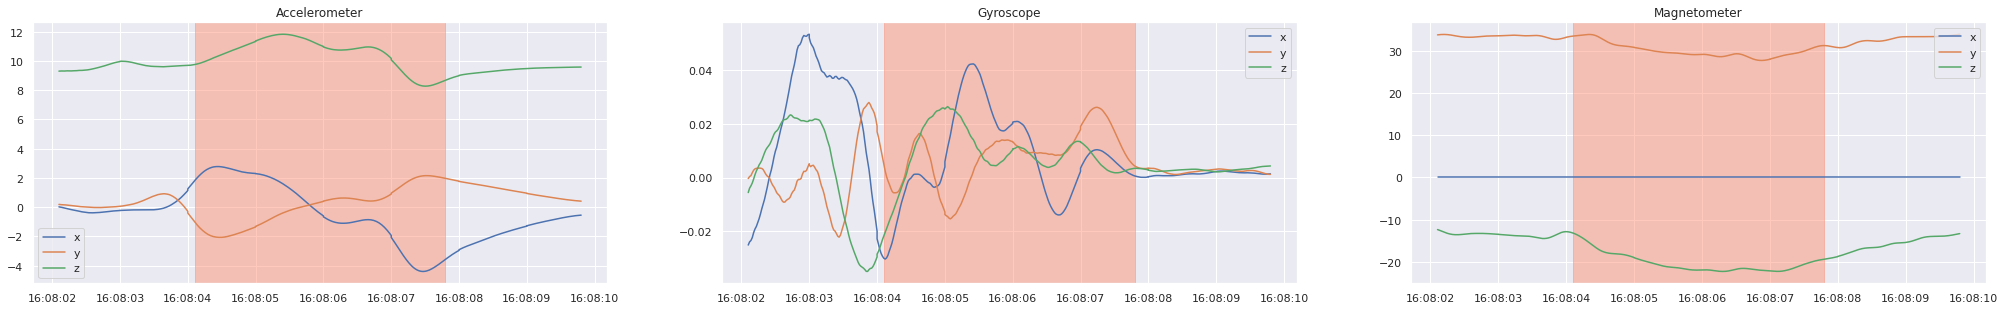

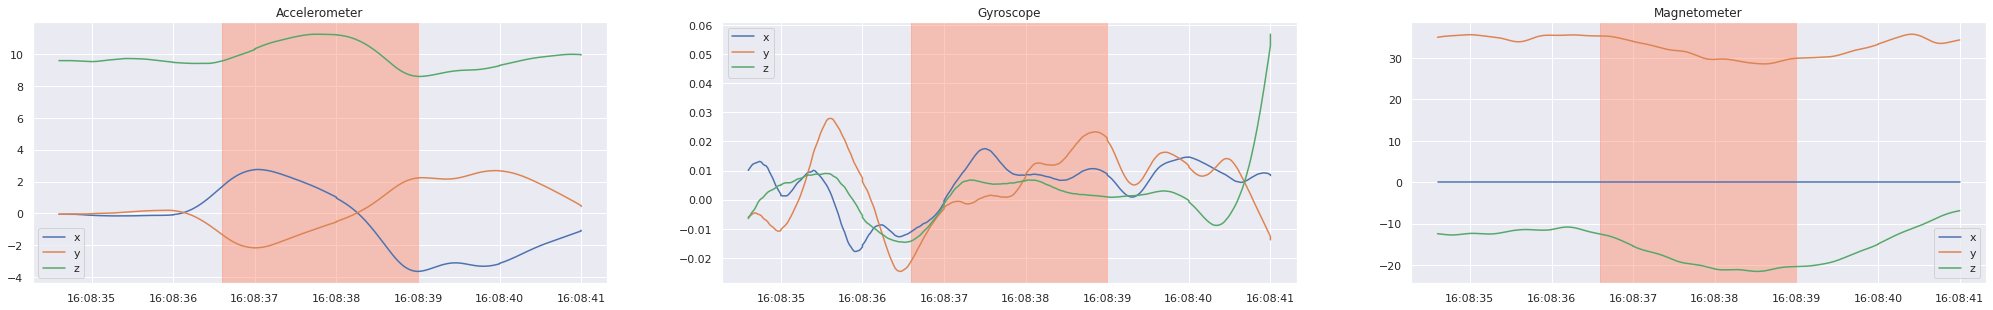

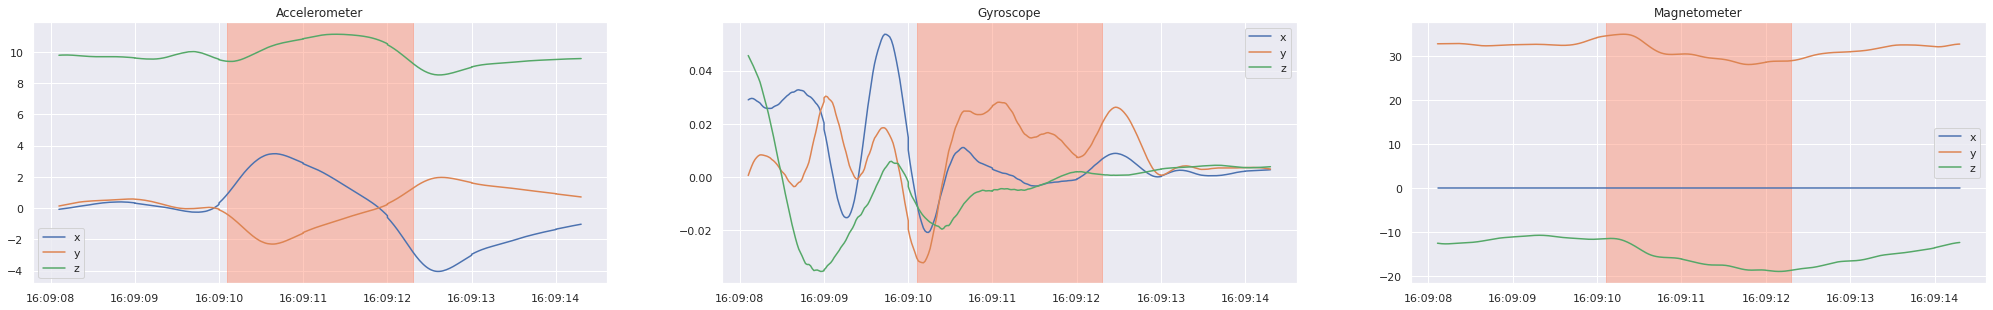

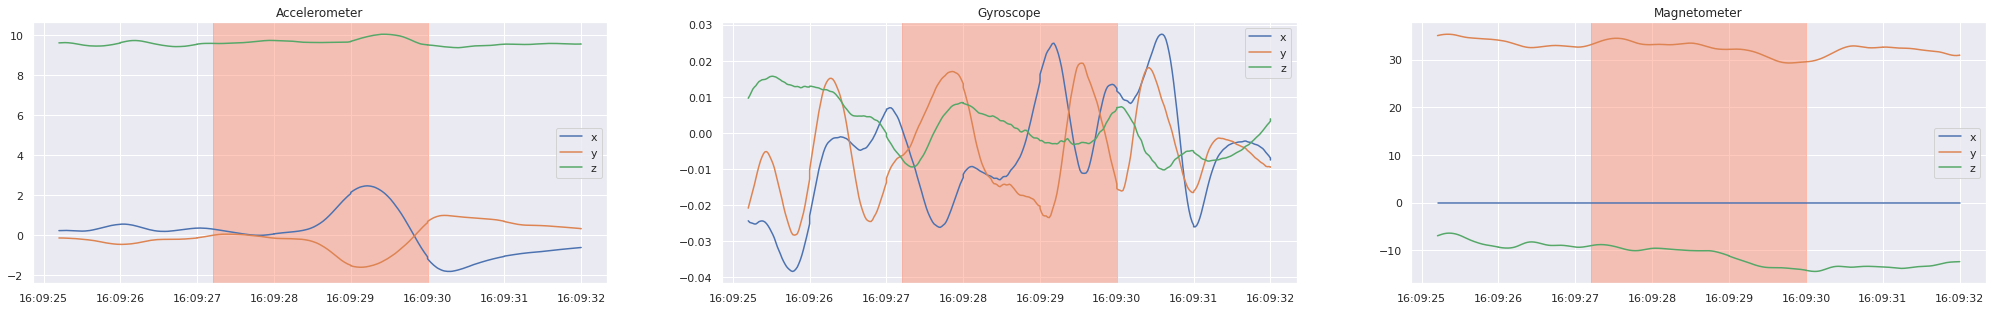

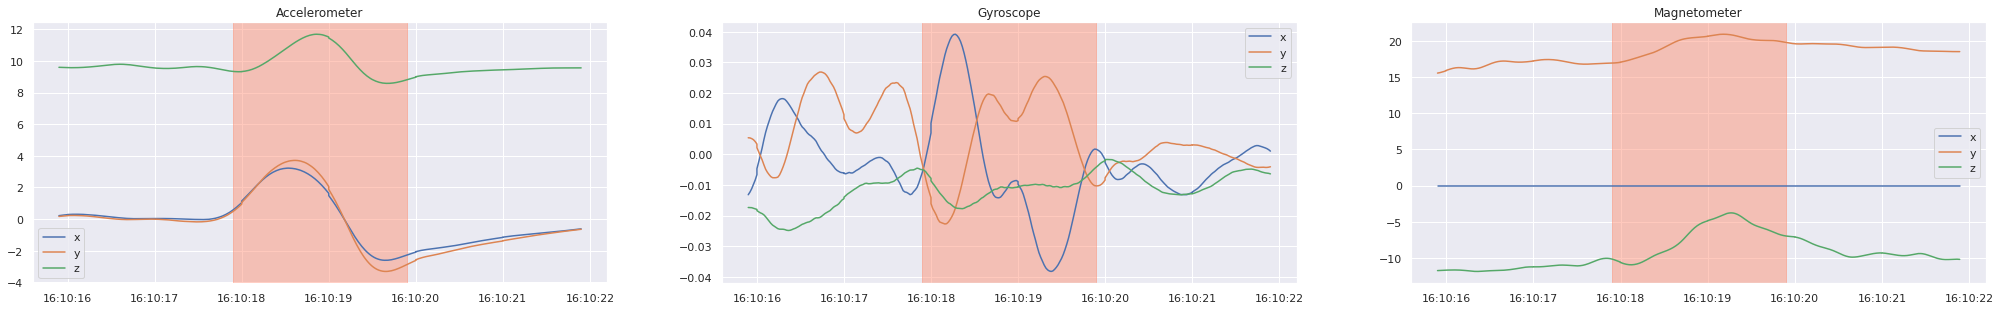

In [ ]:
plot_event([accel4,gyro4,magnet4], truth4, "Aggressive breaking")

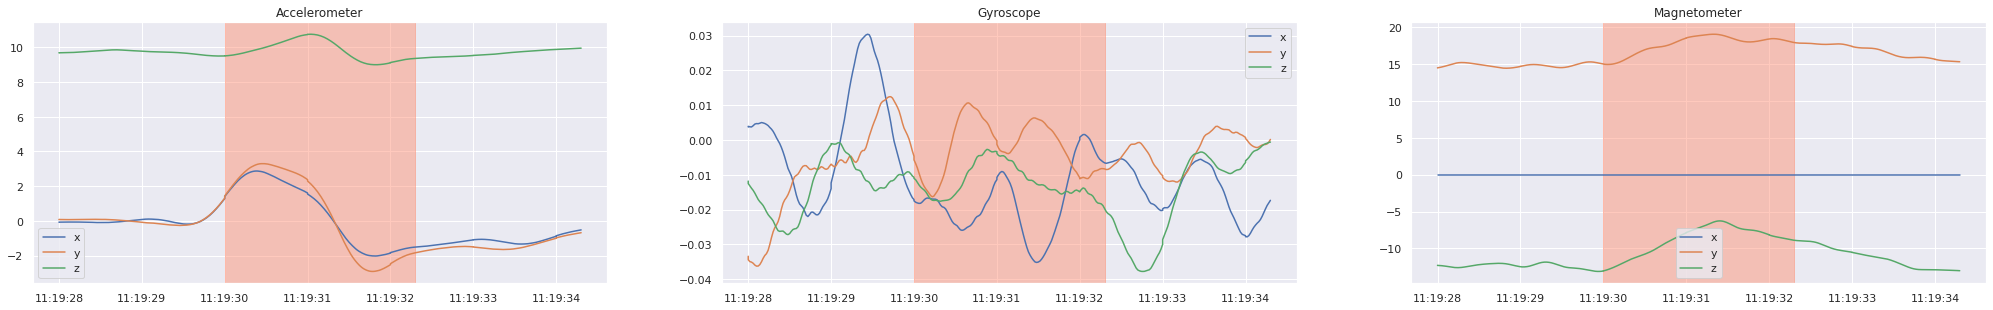

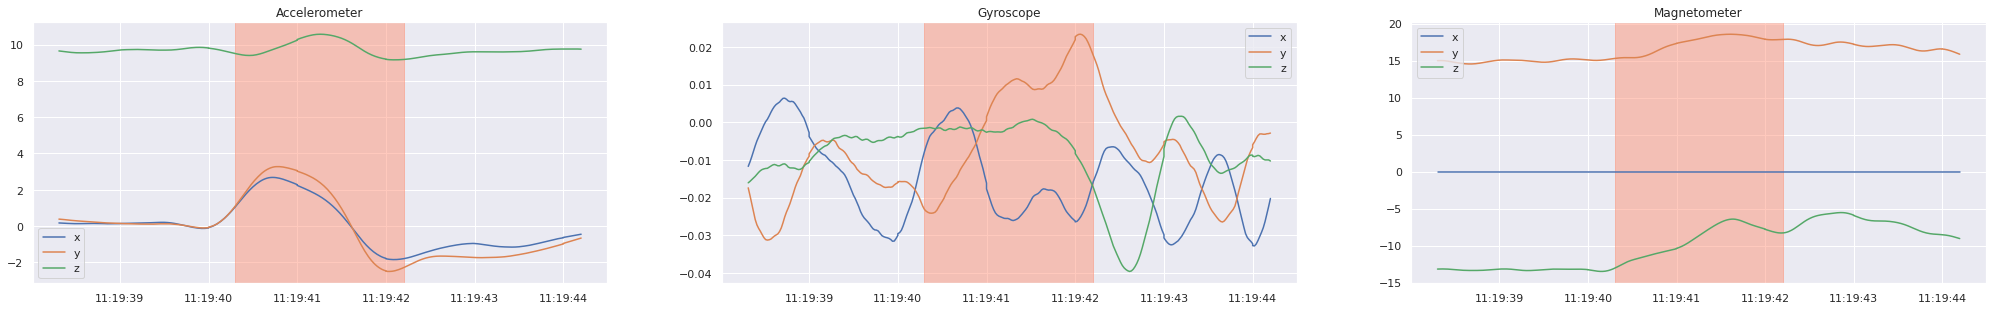

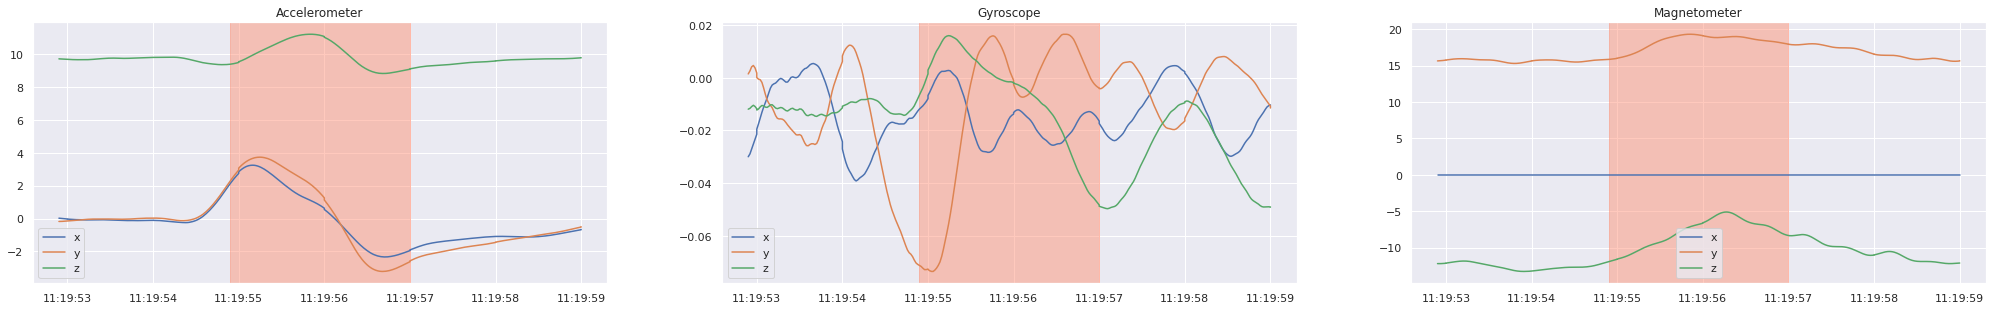

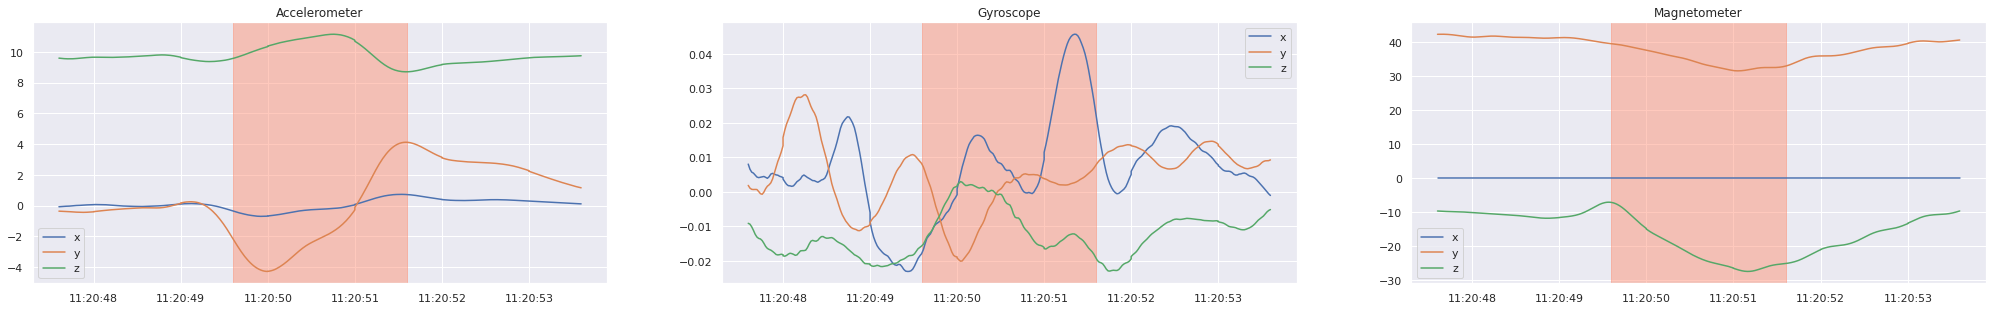

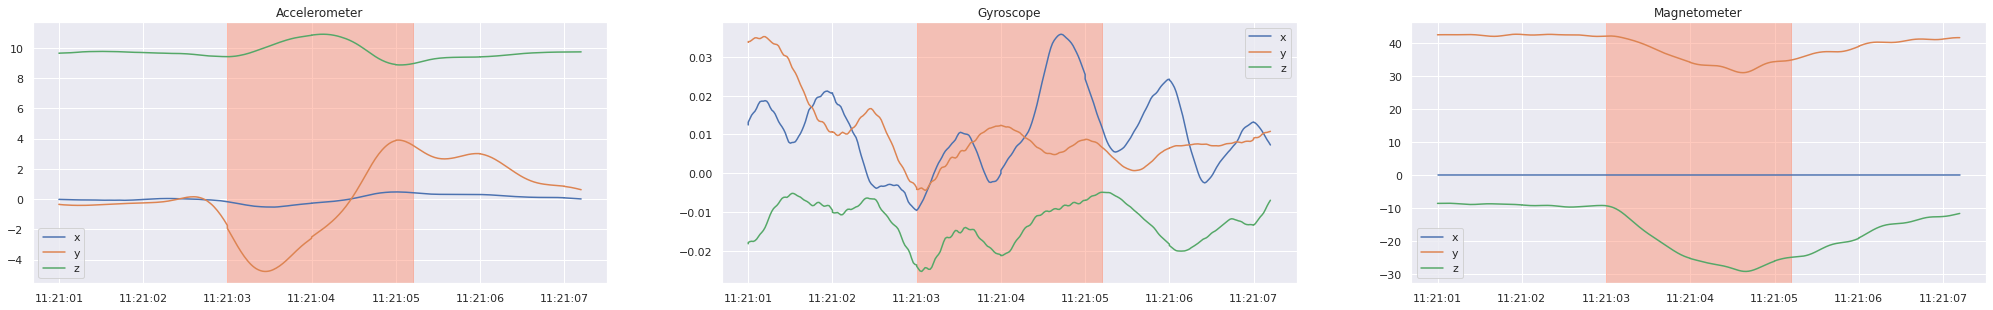

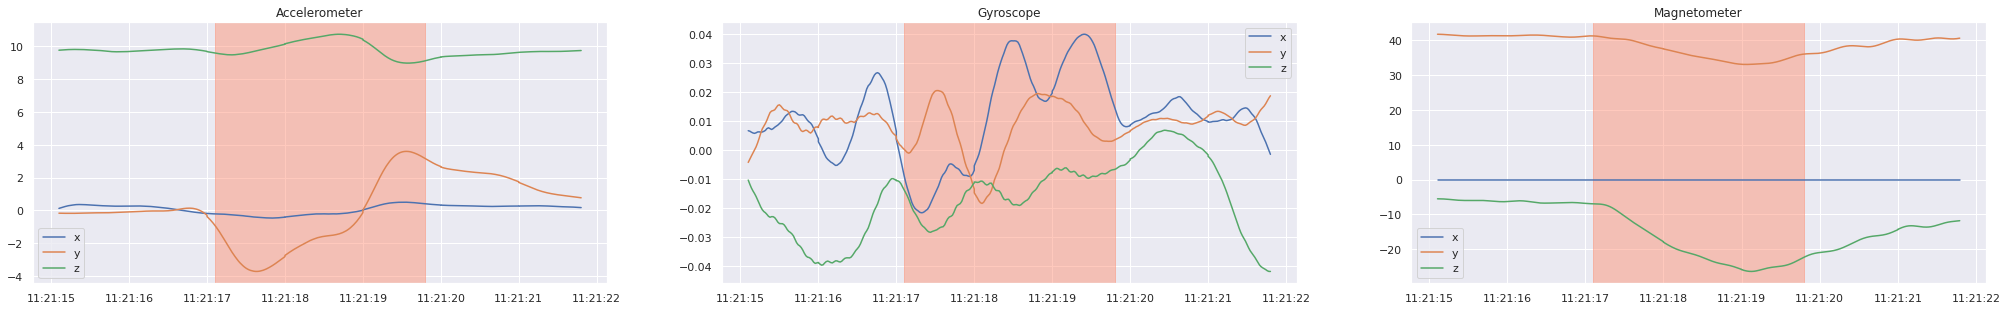

In [ ]:
plot_event([accel2,gyro2,magnet2], truth2, "Aggressive breaking")

## Aggressive Acceleration

There seems to be no visual marker for this maneuver

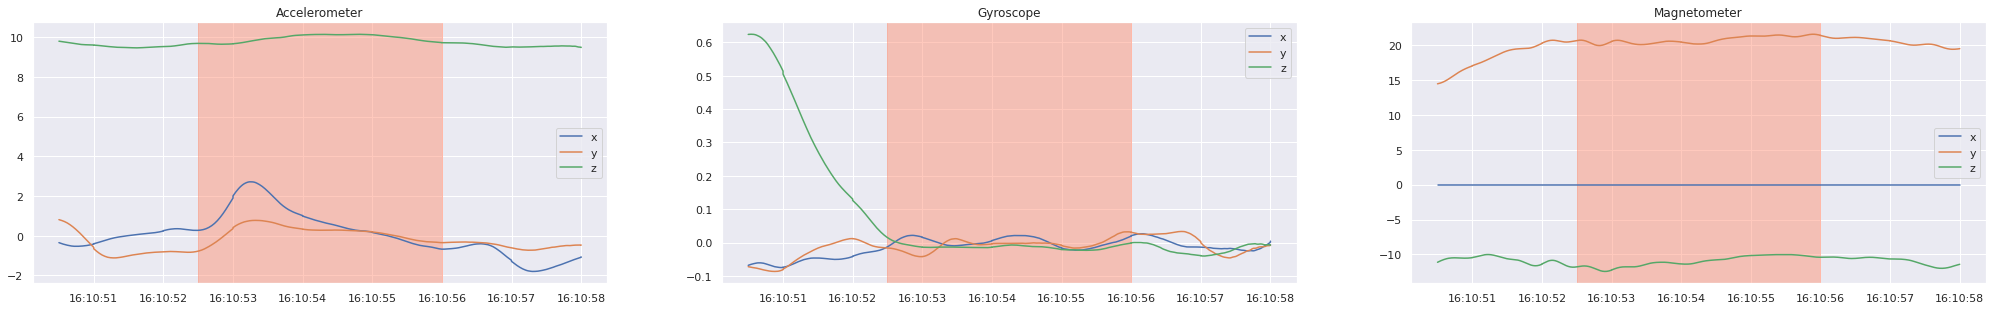

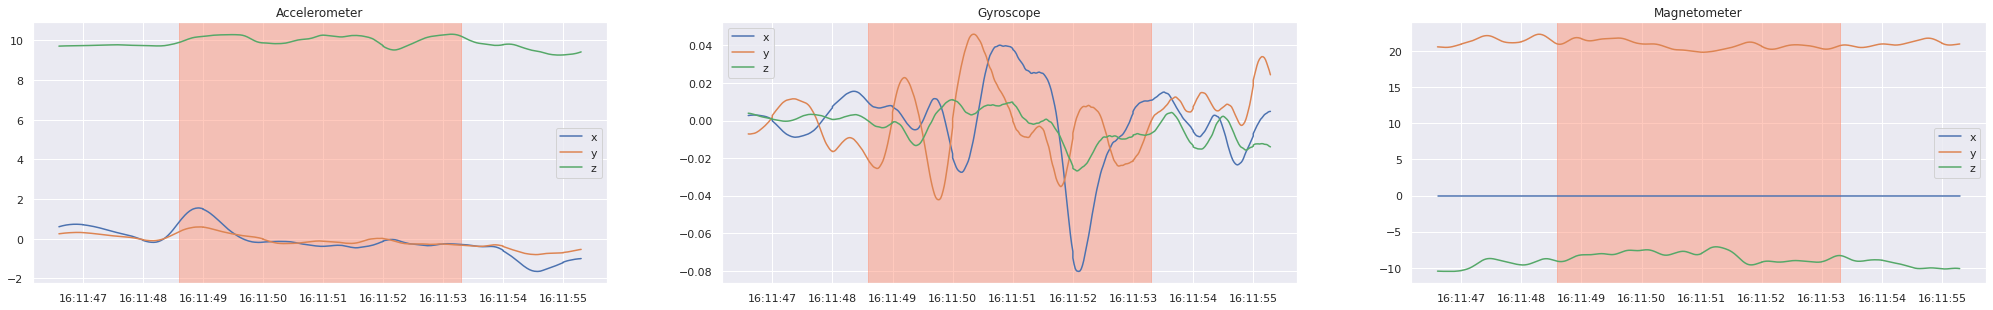

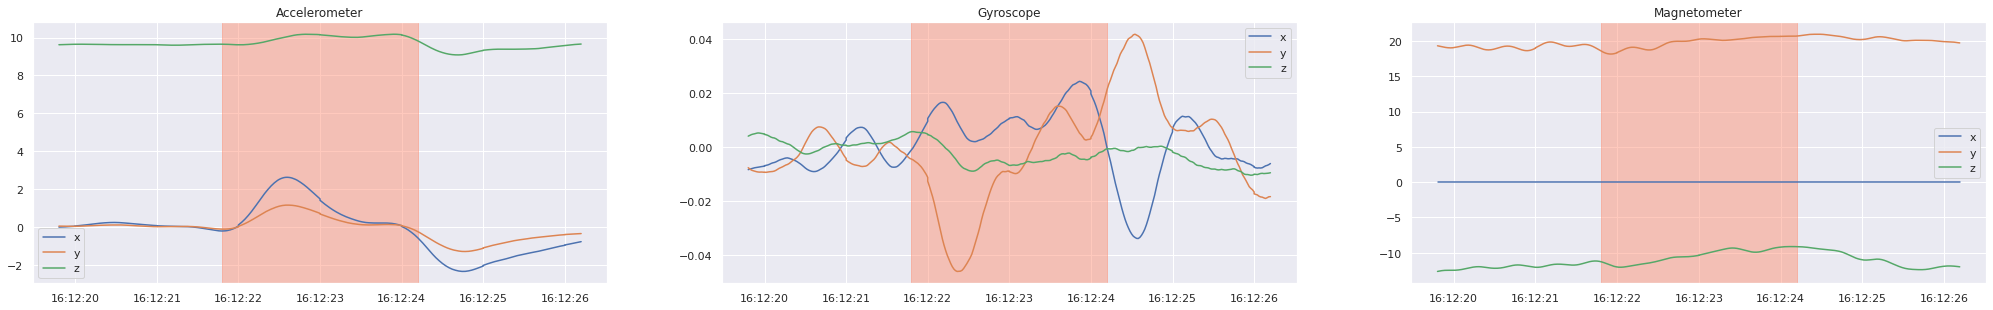

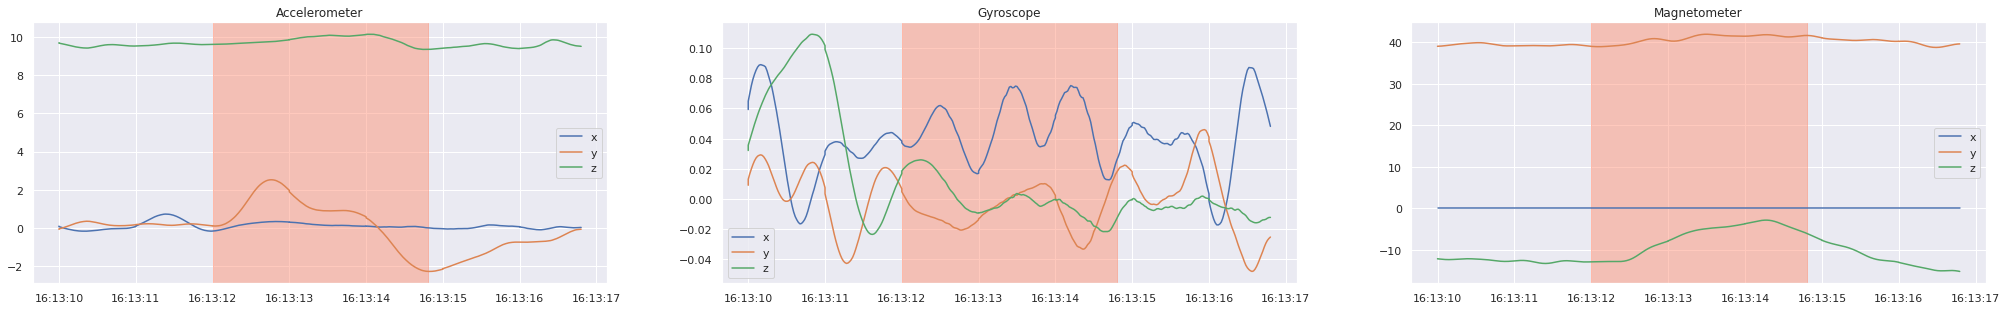

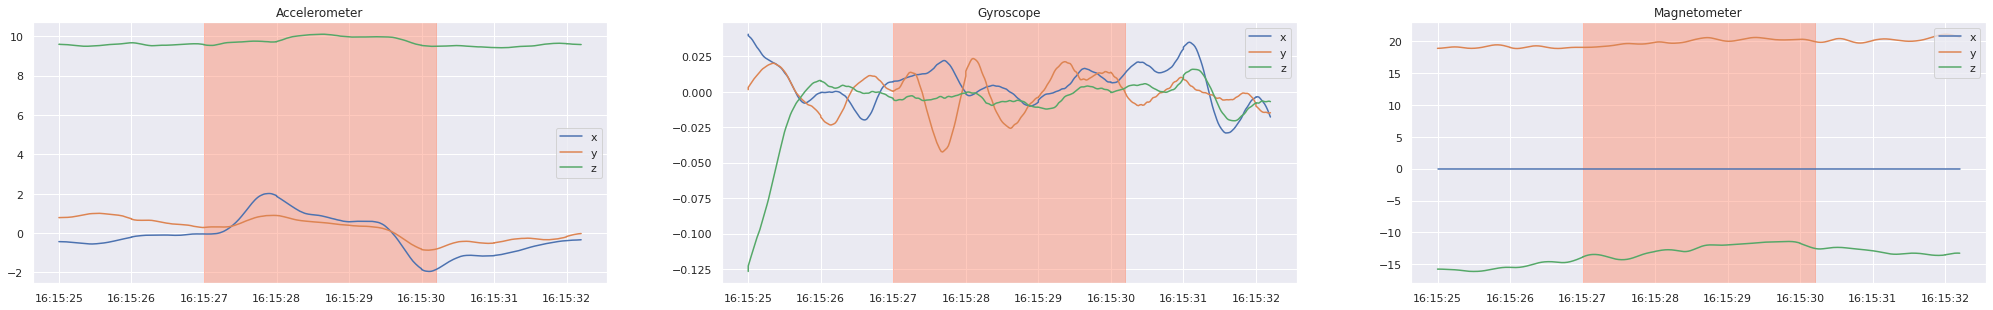

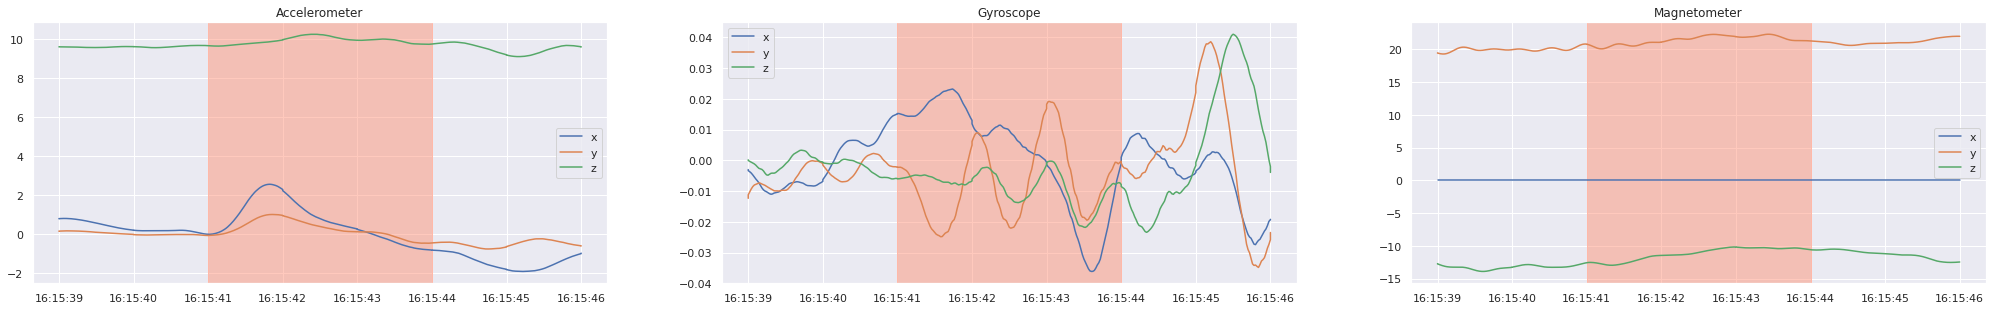

In [ ]:
plot_event([accel4,gyro4, magnet4], truth4, "Aggressive acceleration")

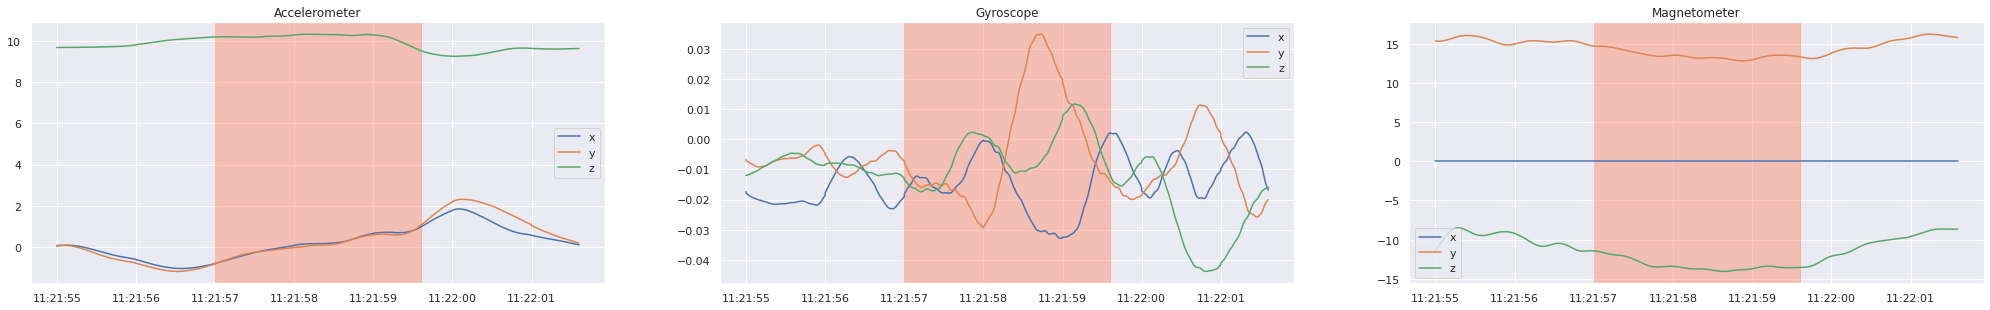

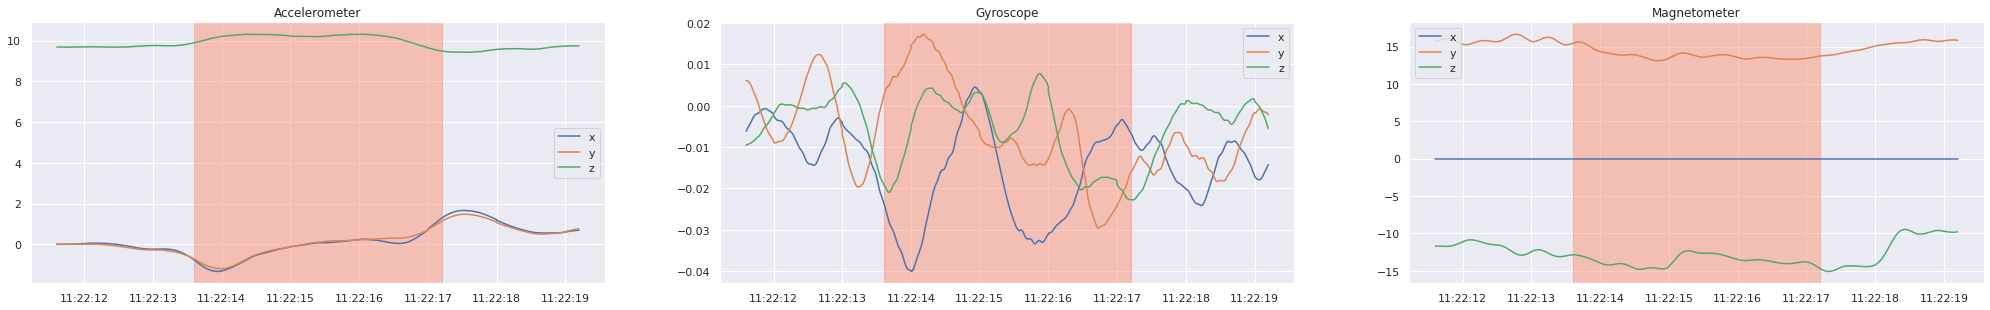

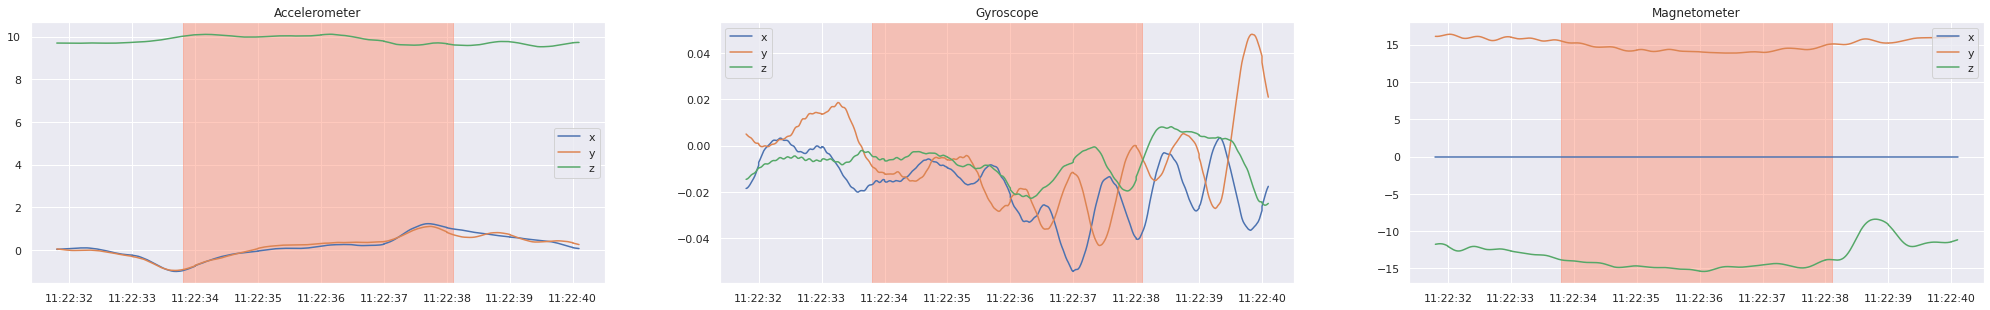

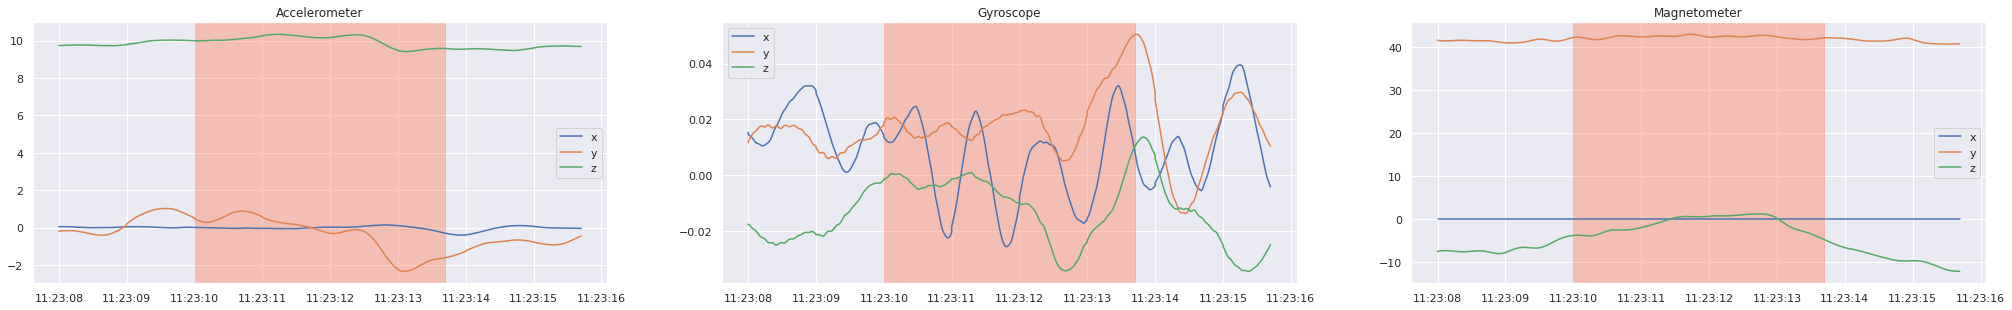

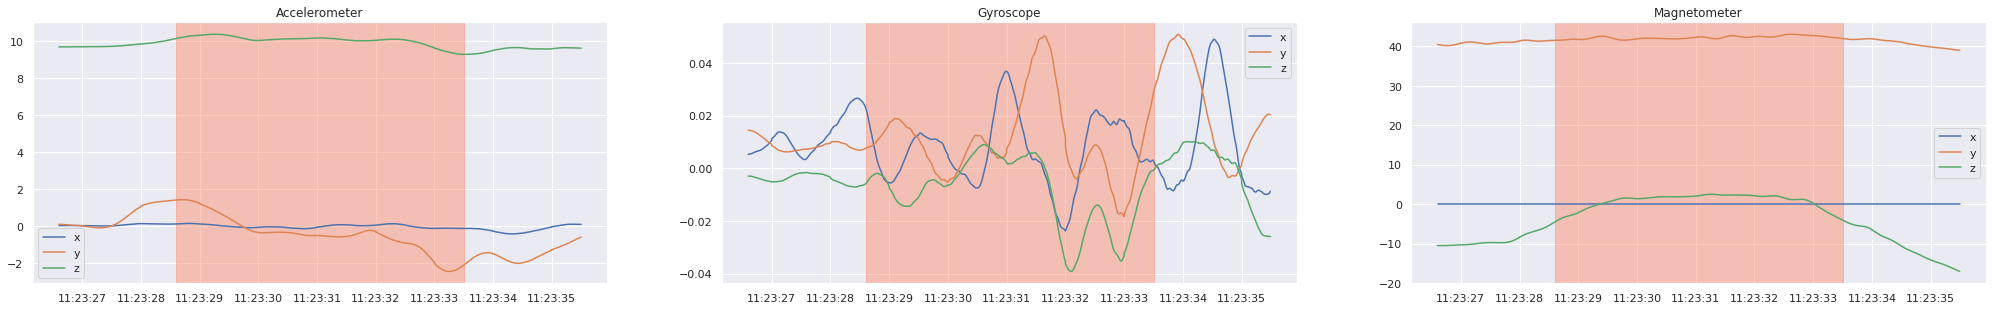

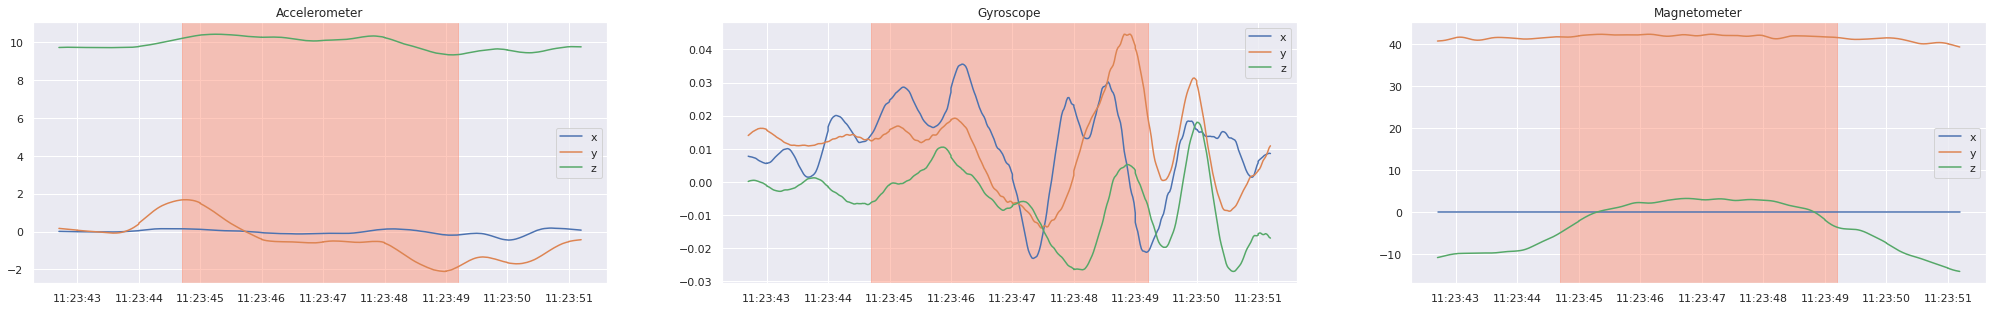

In [ ]:
plot_event([accel2,gyro2, magnet2], truth2, "Aggressive acceleration")

# E Approach

## Loading Data

In [59]:
# def assign_maneuvers(df,truth):
#     """Requires df to be timeseries"""
#     event_no = 0
#     for index, row in truth.iterrows():
#         start = row['Start']
#         finish = row['End']
#         df.loc[((df.index >= start) & (df.index < finish)), 'Event'] = row['Event']
#         df.loc[((df.index >= start) & (df.index < finish)), 'Eventno'] = event_no
#         event_no +=1
#     df["Event"]  = df.Event.fillna("No Maneuver")
#     df["Eventno"]  = df.Eventno.fillna(-1)

def calculate_features(accel,gyro,magnet,truth):
    temp = {'timestamp':[],'f1':[],'f2':[],'f3':[],'f4':[], 'f5':[]}
    windows = create_time_segments(gyro,5)

    for _,window in windows.items():

        # calculating Angular Velocity Feature
        f1 = 0
        for sample in window:
            means = gyro.loc[sample].mean()
            av = np.sqrt(means.x**2  + means.y**2 + means.z**2)
            f1 += av
        f1 /= 3
        
        # calculating Lateral Acceleration Feature
        f2 = accel.loc[window].x.apply(lambda x: x**2).var()

        # calculating Longitudinal Acceleration Feature
        f3 = accel.loc[window].y.apply(lambda x: x**2).var()
        
        # calculating Angle Variation Feature
        f4 = magnet.loc[window].x.apply(lambda x: x**2).var()

        f5 = 0
        for sample in window:
            means = gyro.loc[sample].z.mean()
            f5 += means**2
        f5 *= 2

        temp['timestamp'].append(window[0])
        temp['f1'].append(f1)
        temp['f2'].append(f2)
        temp['f3'].append(f3)
        temp['f4'].append(f4)
        temp['f5'].append(f5)

    data = pd.DataFrame.from_dict(temp)
    # ccel.loc[create_time_windows(accel,3)[0]].x.apply(lambda x: x**2).var()
    data = convert_to_timeseries(data)
    # Uncomment to add_labels
    # add_event_label(data,truth)
    return data


def calculate_features2(accel,gyro,magnet,truth):
    temp = {'timestamp':[],'f1':[],'f2':[],'f3':[],'f4':[], 'f5':[]}
    windows = create_time_segments(gyro,3)

    for _,window in windows.items():

        # calculating Angular Velocity Feature
        f1 = 0
        for sample in window:
            means = gyro.loc[sample].mean()
            av = np.sqrt(means.x**2  + means.y**2 + means.z**2)
            f1 += av
        f1 /= 3
        
        # calculating Lateral Acceleration Feature
        f2 = accel.loc[window].x.apply(lambda x: x**2).var()

        # calculating Longitudinal Acceleration Feature
        f3 = accel.loc[window].y.apply(lambda x: x**2).var()
        
        # calculating Angle Variation Feature
        f4 = magnet.loc[window].x.apply(lambda x: x**2).var()

        f5 = 0
        for sample in window:
            means = gyro.loc[sample].z.mean()
            f5 += means**2
        f5 *= 2

        temp['timestamp'].append(window[0])
        temp['f1'].append(f1)
        temp['f2'].append(f2)
        temp['f3'].append(f3)
        temp['f4'].append(f4)
        temp['f5'].append(f5)

    data = pd.DataFrame.from_dict(temp)
    # ccel.loc[create_time_windows(accel,3)[0]].x.apply(lambda x: x**2).var()
    data = convert_to_timeseries(data)
    # Uncomment to add_labels
    # add_event_label(data,truth)
    return data


turn_color = px.colors.sequential.RdBu
na_color = px.colors.sequential.Teal
colors = {'Aggressive left lane change': turn_color[-4], 'Aggressive left 45-turn': turn_color[-3], 'Aggressive left turn': turn_color[-2], "Aggressive left 180-turn":turn_color[-1], "Aggressive left Overtake": turn_color[-5],
          'Aggressive right lane change': turn_color[3], 'Aggressive right 45-turn':turn_color[2] ,'Aggressive right turn':turn_color[1], "Aggressive right 180-turn": turn_color[0],  "Aggressive right Overtake": turn_color[4],
          'Aggressive acceleration': 'darkviolet', 'Aggressive breaking': 'mediumvioletred', 'Non-aggressive event': na_color[-2],  'No Maneuver': na_color[-2],
          'Aggressive right 90-turn': turn_color[1], 'Aggressive left 90-turn': turn_color[-2]}

labels = {'Aggressive left lane change': "ll", 'Aggressive left 45-turn': "l45", 'Aggressive left turn': "lt", "Aggressive left 180-turn":"lu", "Aggressive left Overtake": "lo",
          'Aggressive right lane change': "rl", 'Aggressive right 45-turn':"r45" ,'Aggressive right turn':"rt", "Aggressive right 180-turn": "ru",  "Aggressive right Overtake": "ro",
          'Aggressive acceleration': 'a', 'Aggressive breaking': "b", 'Non-aggressive event': "na",  'No Maneuver': "nm",
          'Aggressive right 90-turn': "rt", 'Aggressive left 90-turn': "lt"}


def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]),int(rgb[1]),int(rgb[2]))


def add_event_label(data,truth):
    event_no = 0
    for index, row in truth.iterrows():
        start = row['Start']
        finish = row['End']
        data.loc[((data.index >= start) & (data.index < finish)), 'Event'] = row['Event']
        data.loc[((data.index >= start) & (data.index < finish)), 'Eventno'] = event_no
        event_no +=1
    data["Event"]  = data.Event.fillna("No Maneuver")
    data["Eventno"]  = data.Eventno.fillna(-1)
    data["color"] = data.Event.apply(lambda x: colors[x])



In [12]:
path16 = path_jj +"/16/"

path17 = path_jj + "/17/"

path20 = path_jj +"/20/"

path21 = path_jj +"/21/"


portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 'Aggressive left lane change',
                    'aceleracao_agressiva':'Aggressive acceleration','freada_agressiva':'Aggressive breaking',
                   'curva_esquerda_agressiva':'Aggressive left turn','curva_direita_agressiva':'Aggressive right turn',
                  'troca_faixa_direita_agressiva':'Aggressive right lane change'}

accel1 = pd.read_csv(path16 + "acelerometro_terra.csv")
magnet1 = pd.read_csv(path16 + "campoMagnetico_terra.csv")
gyro1 = pd.read_csv(path16 + "giroscopio_terra.csv")
truth1 = pd.read_csv(path16 + "groundTruth.csv")
truth1['evento'] = [portu_to_english[x] for x in truth1['evento']]
truth1.columns = ["Event", "Start", "End"]

accel2 = pd.read_csv(path17 + "acelerometro_terra.csv")
magnet2 = pd.read_csv(path17 + "campoMagnetico_terra.csv")
gyro2 = pd.read_csv(path17 + "giroscopio_terra.csv")
truth2 = pd.read_csv(path17 + "groundTruth.csv")
truth2['evento'] = [portu_to_english[x] for x in truth2['evento']]
truth2.columns = ["Event", "Start", "End"]

accel3 = pd.read_csv(path20 + "acelerometro_terra.csv")
magnet3 = pd.read_csv(path20 + "campoMagnetico_terra.csv")
gyro3 = pd.read_csv(path20 + "giroscopio_terra.csv")
truth3 = pd.read_csv(path20 + "groundTruth.csv")
truth3['evento'] = [portu_to_english[x] for x in truth3['evento']]
truth3.columns = ["Event", "Start", "End"]

accel4 = pd.read_csv(path21 + "acelerometro_terra.csv")
magnet4 = pd.read_csv(path21 + "campoMagnetico_terra.csv")
gyro4 = pd.read_csv(path21 + "giroscopio_terra.csv")
truth4 = pd.read_csv(path21 + "groundTruth.csv")
truth4['evento'] = [portu_to_english[x] for x in truth4['evento']]
truth4.columns = ["Event", "Start", "End"]

savgol(accel1)
savgol(magnet1)
savgol(gyro1,window_length=31,polyorder=3)

savgol(accel2)
savgol(magnet2)
savgol(gyro2,window_length=31,polyorder=3)

savgol(accel3)
savgol(magnet3)
savgol(gyro3,window_length=31,polyorder=3)

savgol(accel4)
savgol(magnet4)
savgol(gyro4,window_length=31,polyorder=3)


In [13]:
"""
Run this if you want to visualize feature variables
"""

accel1 = convert_to_timeseries(accel1)
magnet1 = convert_to_timeseries(magnet1)
gyro1 = convert_to_timeseries(gyro1)



start_time = accel1.index.min()
truth1['Start'] = truth1.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth1['End'] = truth1.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel2 = convert_to_timeseries(accel2)
magnet2 = convert_to_timeseries(magnet2)
gyro2 = convert_to_timeseries(gyro2)

start_time = accel2.index.min()
truth2['Start'] = truth2.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth2['End'] = truth2.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel3 = convert_to_timeseries(accel3)
magnet3 = convert_to_timeseries(magnet3)
gyro3 = convert_to_timeseries(gyro3)

start_time = accel3.index.min()
truth3['Start'] = truth3.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth3['End'] = truth3.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel4 = convert_to_timeseries(accel4)
magnet4 = convert_to_timeseries(magnet4)
gyro4 = convert_to_timeseries(gyro4)

start_time = accel4.index.min()
truth4['Start'] = truth4.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth4['End'] = truth4.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

add_event_label(accel1,truth1)
add_event_label(gyro1,truth1)
add_event_label(magnet1,truth1)

add_event_label(accel2,truth2)
add_event_label(gyro2,truth2)
add_event_label(magnet2,truth2)

add_event_label(accel3,truth3)
add_event_label(gyro3,truth3)
add_event_label(magnet3,truth3)

add_event_label(accel4,truth4)
add_event_label(gyro4,truth4)
add_event_label(magnet4,truth4)


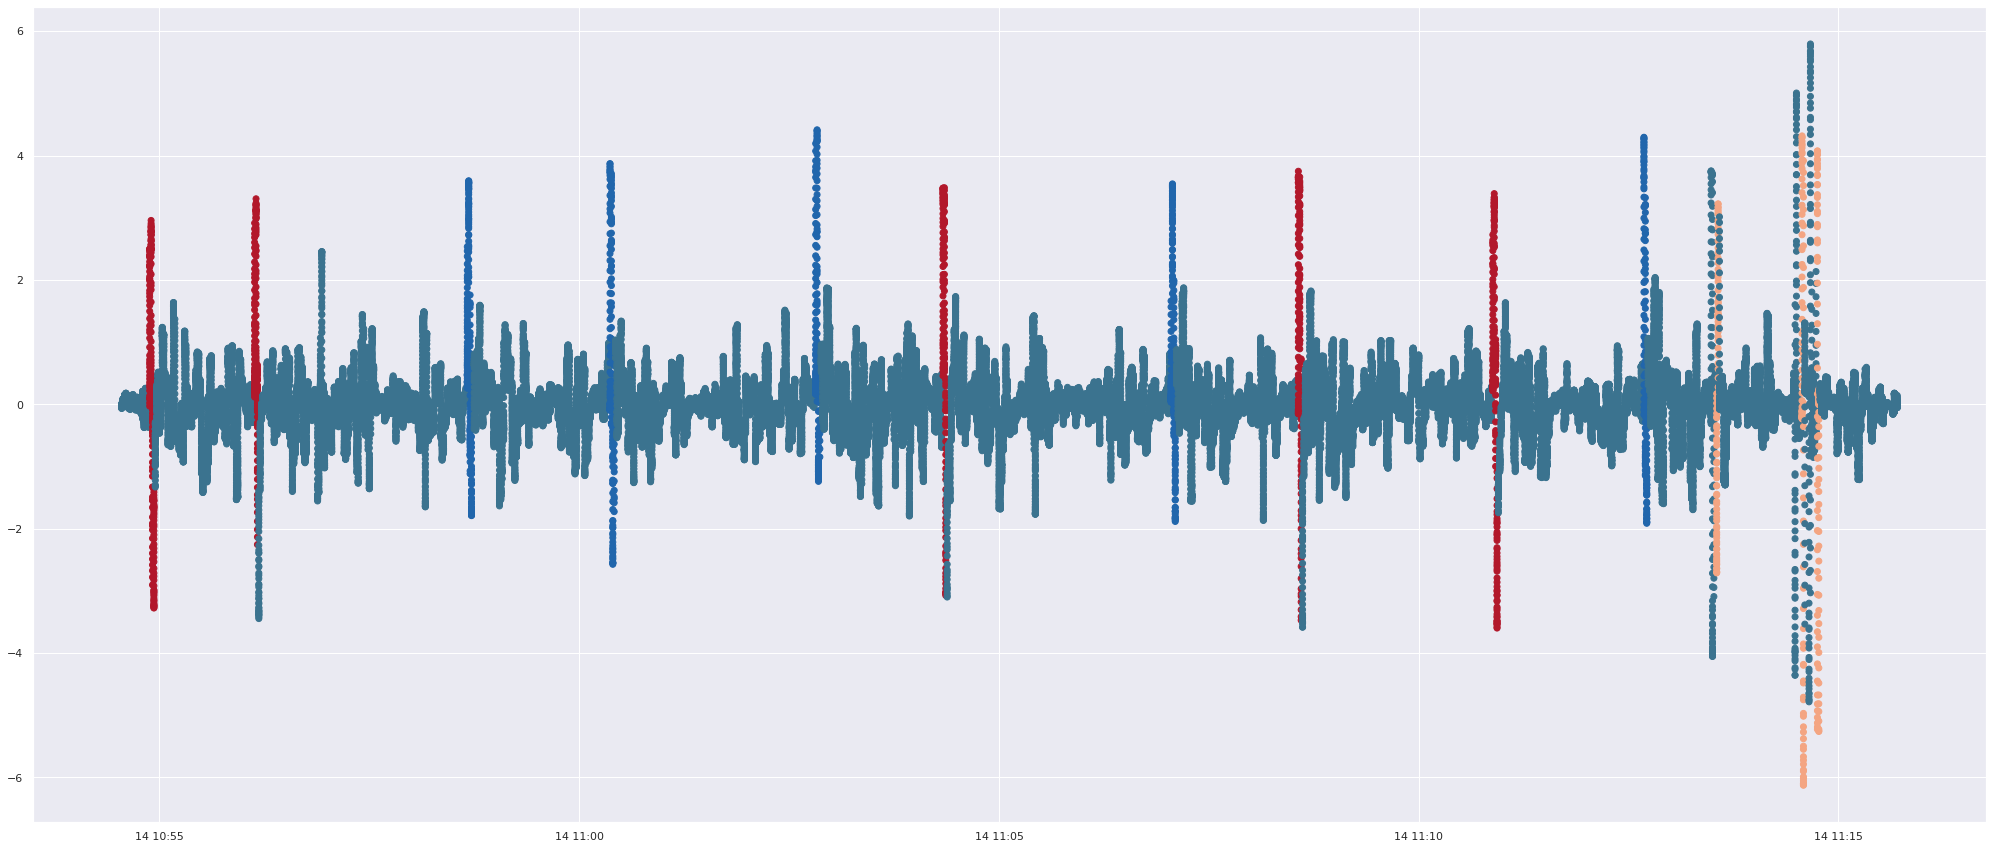

In [14]:
plt.scatter(x = accel1.index, y = accel1.x, c =[rgb_to_hex(y[4:-1].split(',')) for y in accel1.color.values])

## Creating Time segments and calculating features

In [ ]:
# temp = calculate_features(accel1,gyro1,magnet1,truth1)

In [56]:
data1 = calculate_features2(accel1,gyro1,magnet1,truth1)
data2 = calculate_features2(accel2,gyro2,magnet2,truth2)
data3 = calculate_features2(accel3,gyro3,magnet3,truth3)
data4 = calculate_features2(accel4,gyro4,magnet4,truth4)

In [64]:
def get_shape(truth):
    return [dict(
        type="rect",
        # x-reference is assigned to the x-values
        xref="x",
        # y-reference is assigned to the plot paper [0,1]
        yref="paper",
        x0=truth['Start'][i],
        y0=0,
        x1=truth['End'][i],
        # y1=1,
        fillcolor=colors[truth["Event"][i]],
        opacity=0.3,
        layer="below",
    ) for i in truth.index]    

def get_labels(truth):
    return [[2 + 6*i, truth['Start'][i], truth["Event"][i]] for i in truth.index]

def create_figures(data_list = [], truth = []):
    figures = []
    t= 0
    for data in  data_list:
        fig = data.plot()
        fig.update_layout(
            shapes=get_shape(truth[t]))

        # Create scatter trace of text labels
        fig.add_trace(go.Scatter(
        # y =[10+t*7 for i in truth[i].index],
        x = [truth[t]['Start'][i] for i in truth[t].index],
        text=[labels[truth[t]["Event"][i]] for i in truth[t].index],
            mode="text",

        ))

        # fig.update_layout(annotations=[
        #     go.layout.Annotation(x =truth[t]["End"][i],
        #     text=labels[truth[t]["Event"][i]],
        #     align='center',
        #     showarrow=False,
        #     yanchor='bottom',
        #     textangle=90) for i in truth[t].index])

        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                activecolor = "#eefeef",
                buttons=list([
                    dict(count=2, label="2m", step="minute", stepmode="todate"),
                    dict(count=30, label="30s", step="second", stepmode="todate"),

                ])
            )
        )
        figures.append(fig)
        t+=1
    return figures
f = create_figures([data1,data2,data3,data4],[truth1,truth2,truth3,truth4])
for i in f:
    i.show()

## Inspection into these shows that figure f4

In [69]:
data1 = calculate_features2(accel1,gyro1,magnet1,truth1)
# data1 = (data1 - data1.mean()) / data1.std()
fig = data1.plot()
fig.update_layout(
    shapes=get_shape(truth1))
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        activecolor = "#eefeef",
        buttons=list([
            dict(count=2, label="2m", step="minute", stepmode="todate"),
            dict(count=30, label="30s", step="second", stepmode="todate"),

        ])
    )
)
fig.show()

Features 2 and 3 seem to be the best indicators at the moment.

In [67]:

def calculate_features2(accel,gyro,magnet,truth):
    temp = {'timestamp':[],'f1':[],'f2':[],'f3':[],'f4':[], 'f5':[]}
    windows = create_time_segments(gyro,3)

    for _,window in windows.items():

        # calculating Angular Velocity Feature
        f1 = 0
        for sample in window:
            means = accel.loc[sample].mean()
            av = np.sqrt(means.x**2  + means.y**2 + means.z**2)
            f1 += av
        f1 /= 3
        
        # calculating Lateral Acceleration Feature
        f2 = gyro.loc[window].x.apply(lambda x: x**2).var()

        # calculating Longitudinal Acceleration Feature
        f3 = gyro.loc[window].y.apply(lambda x: x**2).var()
        
        # calculating Angle Variation Feature
        f4 = gyro.loc[window].z.apply(lambda x: x**2).var()

        f5 = 0
        for sample in window:
            means = accel.loc[sample].z.mean()
            f5 += means**2
        f5 *= 2

        temp['timestamp'].append(window[0])
        temp['f1'].append(f1)
        temp['f2'].append(f2)
        temp['f3'].append(f3)
        temp['f4'].append(f4)
        temp['f5'].append(f5)

    data = pd.DataFrame.from_dict(temp)
    # ccel.loc[create_time_windows(accel,3)[0]].x.apply(lambda x: x**2).var()
    data = convert_to_timeseries(data)
    # Uncomment to add_labels
    # add_event_label(data,truth)
    return data

In [35]:
def view_feaures(data, truth ):
    figures = []
    for i in  data.columns[:5]:
        fig = data.plot(y = i)
        fig.update_layout(
            shapes=get_shape(truth))

        # # Create scatter trace of text labels
        # fig.add_trace(go.Scatter(
        # y =[10+t*7 for t in truth.index],
        # x = [truth['Start'][t] for t in truth.index],
        # text=[truth["Event"][t] for t in truth.index],
        #     mode="text",
        # ))

        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                activecolor = "#eefeef",
                buttons=list([
                    dict(count=2, label="2m", step="minute", stepmode="todate"),
                    dict(count=30, label="30s", step="second", stepmode="todate"),

                ])
            )
        )
        figures.append(fig)
    return figures

In [36]:
data1.describe()

f1            f2          f3            f4          f5
count  634.000000  6.340000e+02  634.000000  6.340000e+02  634.000000
mean     0.149845  1.781954e+00    0.764690  5.820286e-28    0.348529
std      0.174569  1.010828e+01    4.286477  1.372352e-27    0.597491
min      0.003502  1.063490e-07    0.000015  6.593040e-32    0.000008
25%      0.021050  1.278773e-03    0.002591  6.423646e-29    0.001159
50%      0.058441  1.694953e-02    0.026158  1.592123e-28    0.026510
75%      0.236616  9.605005e-02    0.154136  4.847678e-28    0.456922
max      0.715915  1.284723e+02   52.592240  2.316350e-26    2.930911

In [37]:
features = view_feaures(data1,truth1)
for f in features:
    f.show()

Text(0.5, 1.0, 'Angle Variation Feature')

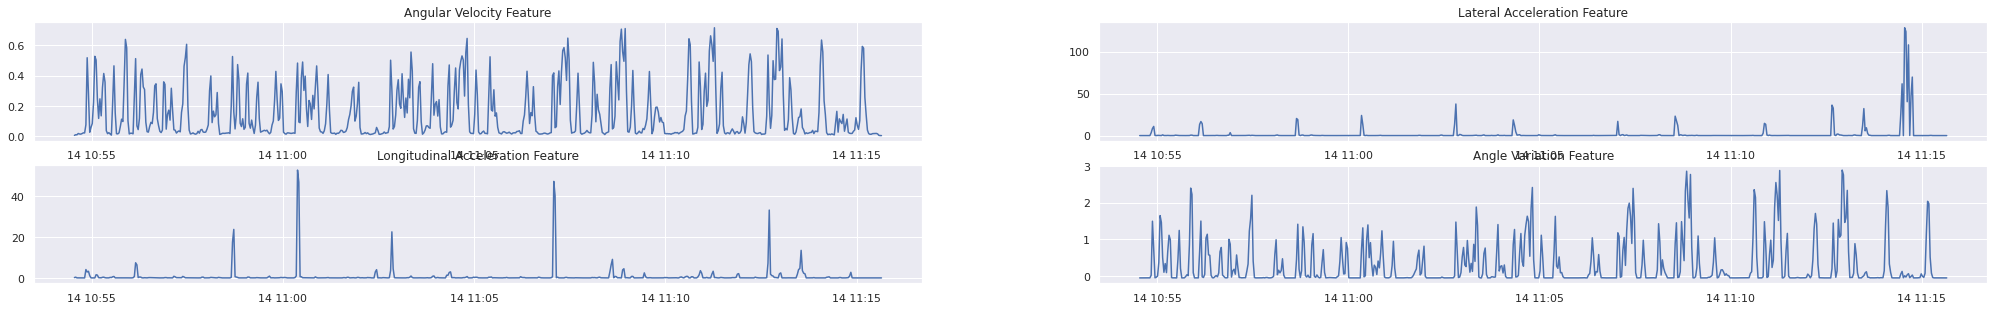

In [38]:
plt.figure(figsize = (35,4.8))
plt.subplot(221)
plt.plot(data1.index,data1.f1 - 0.)
plt.title("Angular Velocity Feature")
plt.subplot(222)
plt.plot(data1.index,data1.f2)
plt.title("Lateral Acceleration Feature")
plt.subplot(223)
plt.plot(data1.index,data1.f3)
plt.title("Longitudinal Acceleration Feature")
plt.subplot(224)
plt.plot(data1.index,data1.f5-0.047)
plt.title("Angle Variation Feature")

# plot_event([data], truth1, "Aggressive right lane change",axes =['f1','f2','f3','f4'], offset = 50)


In [ ]:
def plot_instance_eftekhari(data, start, end,  event, axes= ["f1","f2","f3","f4","f5"], offset = 2):
    """
    Plots one instance of any maneuver between start and end time
    """
    plt.figure(figsize = (35,4.8))

    offset = pd.tseries.offsets.DateOffset(seconds= offset)
    r = 1
    subplot = 1
    mask = (data.index >= (start-offset)) & (data.index <=(end + offset))
    num = 100 + r*10 + subplot
    plt.subplot(num)
    for axis in axes:
        plt.axvspan(start, end, color='#FF9379', alpha=0.2)
        plt.plot(data.index[mask], data[mask][axis])
    plt.legend(["f1","f2","f3","f4","f5"])
    plt.title("Features for {}".format(event))
    subplot+=1
        
def plot_event_eftekhari(data,df_truth, event, axes=["f1","f2","f3","f4","f5"] , offset=2):
    """
    Plots all instances of a maneuver in a given trip
    """
    d = df_truth[df_truth["Event"] == event]
    for i in range(d.count()[0]):
        plot_instance_eftekhari(data, d.iloc[i]['Start'], d.iloc[i]['End'], event, axes, offset)




In [ ]:
px.scatter_matrix(t,dimensions=["f1",'f2','f3','f4',"f5"],color = "color")